<a href="https://colab.research.google.com/github/ConradBitt/repositorio_monografia/blob/main/Mapa_linear_por_partes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações, importações e instalações




In [1]:
# Versão Ubuntu
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.5 LTS
Release:	18.04
Codename:	bionic


In [2]:
# Instalando fortran e gnuplot
!apt-get install gfortran
!apt-get install gnuplot

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gfortran is already the newest version (4:7.4.0-1ubuntu2.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gnuplot is already the newest version (5.2.2+dfsg1-2ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [3]:
!pip install pyunicorn
!pip install statsmodels=='0.12.2'
!pip install scipy=='1.7.1'
!pip install numpy=='1.21.0'

In [4]:

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import ticker as tkr
from matplotlib import colors as mcolors
mpl.rcParams["axes.formatter.use_mathtext"] = True

import numpy as np 
import seaborn as sns
import pandas as pd
import IPython.display as IPythonNB

import scipy.stats as scipy_stats
from google.colab import drive
from scipy.stats import normaltest
from scipy.stats import hmean
import scipy.linalg as la
from pyunicorn.timeseries import RecurrenceNetwork, RecurrencePlot

from sklearn.preprocessing import MinMaxScaler, StandardScaler

semente = 1458513866
#sns.set_context('talk')
plt.style.use('bmh')

cm = 1/2.54

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### <b><font color='red'>AVISO</font></b>

Muitas vezes ao executar o PyUnicorn da um erro do tipo ``ModuleNotFoundError: No module named 'setup'``. Quando isso acontecer, e vai acontecer, entre no arquivo "/usr/local/lib/python3.7/dist-packages/pyunicorn/__init__.py" e comente a linha 43 onde esta escrito:
```python
from setup import __version__
```
adicione um # na linha

```python
#from setup import __version__
```
salve com Ctrl+S e reinicie o ambiente de execução indo em "Ambiente de execução" ---> "Reiniciar e executar tudo". 

Códigos Auxiliares

# Funções auxiliares

## Definindo funções auxiliares (python)


In [5]:
# função do formatador leva o rótulo do tick e a posição do tick 
def func(x, pos):
    s = str(np.round(x,2))
    ind = s.index('.')
    return s[:ind] + ',' + s[ind+1:]   # trocando ponto por vírgula

formatador = tkr.FuncFormatter(func)  # criando formatador


Nesta etapa vou criar algumas funções para realizar os cálculos e as exibições gráficas.

## Função para iterar mapa

In [6]:
def itera_mapa(f, x0, n):
    """
    Itera o mapa f(x) começando em x0 por n instantes de tempo.
    - f: função lambda a ser iterada.
    - x_0: condição inicial 
    - Precisão: 
    Retorna um numpy.array com n+1 valores x[0], ..., x[n].
    """
    x = np.zeros(n+1)
    x[0] = x0
    xt = Decimal(x0)
    for t in range(n):
        xt = f(xt)
        x[t+1] = xt
    return x

## Função para exibir Cobweb plot

In [7]:
def cobweb_plot(f, x_0, n_iteracoes, range_x, figsize, titulo='', legenda=False, labels_axis = ('x_t','x_{t+1}')):
    """
    Exibe Cobweb plot
    - f: funcao lambda a ser iterada
    - x_0: condição inicial
    - n_iteracoes: quantidade de passos (iteracoes)
    - eq_latex: string com equação em LaTeX
    - range_x: tupla com limite inferior e superior de x
    - figsize: tupla com comprimento X altura (em centimentros)

    return: (X,Y), figura
    """
    cm = 1/2.54
    figsize = (figsize[0]*cm, figsize[1]*cm)
    quantidade_iteracoes = n_iteracoes

    pontos = []
    pontos.append((x_0, f(x_0)))

    for iteracao in range(quantidade_iteracoes):
        x, y = pontos[-1]
        y = f(x)
        pontos.append((x,y))
        x = y 
        pontos.append((x,y))

    vetor_resultados = np.array(pontos).T
    X, Y = vetor_resultados

    axis_min, axis_max = range_x

    eixo = np.linspace(axis_min, axis_max, 100)
    f_x = np.array([f(x) for x in eixo])
    
    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xlim(min(eixo), max(eixo))
    ax.set_ylim(min(eixo), max(eixo))
    ax.set_xlabel(f'${labels_axis[0]}$', fontsize=20)
    ax.set_ylabel(f'${labels_axis[1]}$', fontsize=20)

    ax.plot(eixo, eixo, linewidth=1, linestyle='--')
    ax.plot(eixo, f_x, color='green', label=r'$f(x)$')
    ax.hlines(y = 0, xmin=min(eixo), xmax = max(eixo), color='black', alpha=0.5)

    ax.plot(X[1:],Y[1:], color='blue', linewidth=0.5, label='Trajetória')
    ax.vlines(x_0, 0.0, Y[1], color='red', label='C.I.')
    ax.set_title(f'{titulo}', pad=20, fontsize=20)
    
    if legenda:
      ax.legend(loc='upper left')

    #sns.histplot(np.array(Y), bins=50, ax=ax[1])
    #ax[1].set_title(r'Distribuição de $x_{n+1}$ ao longo das iterações', pad=20, fontsize=20)
    #ax[1].set_xlabel(r'$x_{n+1}$', fontsize=18)
    #ax[1].set_ylabel(r'Frequência', fontsize=18);

    # Formatando os pontos pra vírgula
    ax.yaxis.set_major_formatter(formatador)
    ax.xaxis.set_major_formatter(formatador)
    
    return vetor_resultados, fig

## Função para exibir Diagrama de Bifurcação

In [8]:
import random

def bifurcacao_plot(f, xs_0, n_iteracoes, r, titulo, figsize, linhas_verticais=False, labels_axis = ('r','x_{t+1}')):
    """
    Exibe diagrama de bifurcacao
    - f(x,r): função lambda a ser iterada (função lambda)
    - xs_0: lista de condições iniciais (CI's)(array)
    - n_iteracoes: quantidade de iterações (int)
    - r: espaço de parâmetros r (array)
    - titulo: string com título, $LaTeX$
    - figsize: tupla com comprimento X altura (em centimentros)

    return: (X_n, r), figura
    """
    cm = 1/2.54
    figsize = (figsize[0]*cm, figsize[1]*cm)

    resultados_bif = []
    for parametro_controle in r:
        x_0 = random.choice(xs_0) # Seleciona um valor das CI's
        x = itera_mapa(lambda x: f(x, Decimal(parametro_controle)),
                        Decimal(x_0), n_iteracoes)
        xn = x[-1]
        resultados_bif.append((xn, parametro_controle))

    resultados_bif = np.array(resultados_bif).T
    X_n_bif, espaco_r_bif = resultados_bif

    fig, ax = plt.subplots(figsize = figsize)

    ax.scatter(espaco_r_bif, X_n_bif, s=0.2, c='black')
    if linhas_verticais:
      i=0
      cores = ['blue','green','orange','red']
      for ponto in linhas_verticais:
        ax.vlines(ponto, min(X_n_bif)-1, max(X_n_bif)+1, color=f'{cores[i]}', label=f'({(string.ascii_uppercase[i])}) ${labels_axis[0]}={str(ponto).replace(".",",")}$')
        i += 1


    ax.legend()
    ax.set_ylim(min(X_n_bif), max(X_n_bif))
    ax.set_xlim(min(espaco_r_bif), max(espaco_r_bif))

    ax.set_ylabel(f'${labels_axis[1]}$',fontsize=20, rotation=0)
    ax.set_xlabel(f'Parâmetro de controle ${labels_axis[0]}$',fontsize=20)
    ax.set_title(f'{titulo}',fontsize=20, pad=20)

    # Formatando os pontos pra vírgula
    ax.yaxis.set_major_formatter(formatador)
    ax.xaxis.set_major_formatter(formatador)

    return resultados_bif, fig


## Função para exibir Espectro de Lyapunov

In [9]:
from scipy.misc import derivative
import string


def expectro_lyapunov_plot(f, x_0, n_iteracoes, r, titulo, figsize, linhas_verticais=False, labels_axis = ('r','\lambda_r')):
    """
    Exibe o expectro de lyapunov
    - f(x,r): função lambda que representa o mapa
    - x_0: condição inicial da trajetória
    - n_iteracoes: quantidade de iterações do mapa
    - r: array com os parâmetros de controle 
    - titulo: string com equação escrita em LaTeX
    - figsize: tupla com comprimento X altura (em centimentros)

    return: (exp_lyap, r), figura
    """
    cm = 1/2.54
    figsize = (figsize[0]*cm, figsize[1]*cm)

    resultados_exp_lyap = []

    for parametro_controle in r:
        
        treajetoria_1 = itera_mapa(lambda x: f(x, Decimal(parametro_controle)),
                                   Decimal(x_0), n_iteracoes)
        
        exp_lyapunov = np.mean(np.log(np.abs([derivative(lambda x: f(x, parametro_controle), k, dx=1e-6) for k in treajetoria_1])))

        resultados_exp_lyap.append((exp_lyapunov, parametro_controle))

    resultados_exp_lyap = np.array(resultados_exp_lyap).T
    X_n_exp_lyap, espaco_r_exp_lyap = resultados_exp_lyap

    fig, ax = plt.subplots(figsize = figsize)
    ax.set_ylim(-1,max(X_n_exp_lyap))
    ax.set_xlim(min(r), max(r))
    #fig.set_size_inches(10, 8)

    ax.scatter(espaco_r_exp_lyap, X_n_exp_lyap, s=0.2, c='black')
    #plt.hlines(y=0.0, xmin=min(r),xmax=max(r),color='black', linewidth=0.5)
    ax.set_ylabel(f'${labels_axis[1]}$',fontsize=20, rotation=0)
    ax.set_xlabel(f'Parâmetro de controle ${labels_axis[0]}$', fontsize=20)
    ax.set_title(f'{titulo}', pad=20, fontsize=20)

    if linhas_verticais:
      i=0
      cores = ['blue','green','orange','red']
      for ponto in linhas_verticais:
        ax.vlines(ponto, min(X_n_exp_lyap)-1, max(X_n_exp_lyap)+1, color=f'{cores[i]}', label=f'({(string.ascii_uppercase[i])}) ${labels_axis[0]}={str(ponto).replace(".",",")}$')
        i += 1

    ax.legend()
    
    # Formatando os pontos pra vírgula
    ax.yaxis.set_major_formatter(formatador)
    ax.xaxis.set_major_formatter(formatador)
  
    return resultados_exp_lyap, fig

# Funções de visualização

# Funções de visualização

In [10]:
def spatial_temporal(rede, iteracao=2000, periodo = 1, figsize=(12,10)):
    iteracoes_selecionadas = np.arange(1, rede.get_tempo(), periodo)
    fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(figsize[0]*cm, figsize[1]*cm))

    rede_filtrada = rede.get_spatial_temporal()[iteracoes_selecionadas].iloc[:,-100:].T[::-1]

    sns.heatmap(data = rede_filtrada, cmap='jet',
                cbar_kws={"format": formatador,'label': 'Estado $x_{t}^{i}$'},
                ax=ax)
    ax.set_title(f'$\sigma = {rede.get_sigma()}$', pad=20)
    ax.set_ylabel('Iteração $t$')
    ax.set_xlabel('Mapa $i$')
    
    return fig


In [11]:
def spatial_profile(rede, iteracao, figsize=(12,10)):
    fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(figsize[0]*cm, figsize[1]*cm))
    sns.scatterplot(data = rede.get_spatial_temporal().iloc[:,iteracao], ax=ax, s=30)
    ax.yaxis.set_major_formatter(formatador)
    ax.set_ylabel('Estado $x_t^i$')
    ax.set_xlabel('Mapa $i$')
    #ax.set_ylim(-1,1)
    ax.set_title(f'Perfil espacial na iteração {iteracao}', pad=20)
    return fig



In [12]:
def plot_recurrence_matrix(rede, iteracao=1998, figsize=(12,10)):
    iteracao = int(iteracao)
    fig, ax = plt.subplots(figsize=(figsize[0]*cm, figsize[1]*cm))
    img = ax.matshow(rede.get_matrix_recurrences_spatial()[iteracao],
                    vmin=0, vmax=1, cmap='binary')
            
    ax.set_ylabel(r'$ x_{t}^{i}$',fontsize=18)
    ax.set_xlabel(r'$ x_{t}^{j}$',fontsize=18)

    # Aspectos eixo 2
    caracteristica_mapa_rr = f'\t\t $\epsilon = 0,05$'
    sigma = str(rede.get_sigma()).replace('.',',')
    titulo_ax2 = f'$\sigma = {sigma} $'
    ax.set_title(titulo_ax2 + caracteristica_mapa_rr, pad=20)
    cbar_ax = fig.add_axes([.90, 0.04, 0.04, 0.9]) 
    fig.colorbar(img, cax=cbar_ax,label='Valor Matriz Recorrência', format=formatador)
    return fig

In [13]:
def comprimentos_matriz_rec(rede, iteracao, parametro):
    parametros = ['Prob_l','Prob_v', 'Prob_w']
    if parametro in parametros:
        dist = np.array(rede.get_params_recurence_analysis_spatial()[parametro][iteracao].replace('\n','').replace('  ',' ').replace('  ',' ').replace(' ',',').replace(',','',1)[1:-1].split(','))
        dist = pd.Series([int(i) for i in dist])
        return dist
    else:
        raise Exception(f'Escolha um parâmetro: {parametros}')
    

In [14]:
def freq_comprimento_matriz_recorrencia(rede, iteracao, parametro, n=35, figsize=(12,10)):
    if parametro == 'Prob_v':
        cor = 'green'
    elif parametro == 'Prob_l':
        cor = 'red'
    else:
        cor = 'blue'

    dist_fret_comprimento = comprimentos_matriz_rec(rede, iteracao, parametro).to_frame().reset_index()
    dist_fret_comprimento.columns = [f'comprimento_{parametro}','quantidade']

    fig, ax = plt.subplots(figsize=(figsize[0]*cm, figsize[1]*cm))
    sns.barplot(y = 'quantidade', x = f'comprimento_{parametro}', color=cor, data = dist_fret_comprimento.iloc[1:n])
    ax.set_ylabel(f'$P({parametro[-1]})$')
    ax.set_xlabel(f'Comprimento ${parametro[-1]}$')
    ax.set_title(f'$\sigma = {str(rede.get_sigma()).replace(".",",")}$')
    return fig


# Funções para iterar as redes

## Definindo função a ser iterada

# Linear por partes



In [15]:
from decimal import Decimal 
# parâmetros
p1 = -0.5
#l = 1.5
p2 = -2.4

# fuções lineares 


def linear_por_partes(x, l):
    x = float(x)
    l = float(l)
    
    f1 = lambda x : p1 * x + (p1 / l - 1) 
    f2 = lambda x : l * x 
    f3 = lambda x : p2 * x - (p2 / l - 1) 

    if -1 <= x < -1 / l:
        return f1(x)
    if -1 / l <= x < 1/l:
        return f2(x)
    if 1/l < x <= 1:
        return f3(x)

## Cobweb plot

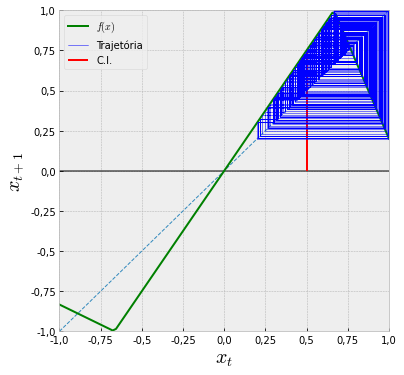

In [16]:
cobweb_picewise_27_positiv,fig_picewise_27_positiv = cobweb_plot(
    f = lambda x : linear_por_partes(x, 1.5),
    x_0 = 0.5,
    n_iteracoes = 250,
    range_x = (-1,1),
    figsize=(15,15),
     titulo='',
    legenda=True);

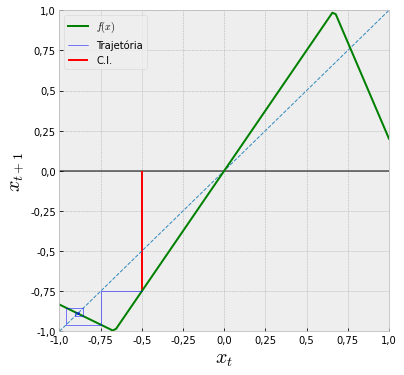

In [17]:
cobweb_picewise_27_negative, fig_picewise_27_negative = cobweb_plot(
    f = lambda x : linear_por_partes(x, 1.5),
    x_0 = -0.5,
    n_iteracoes = 250,
    range_x = (-1,1),
    figsize=(15,15), titulo='',
    legenda=True);

### Ponto Fixo

In [18]:
x_linear_picewise = itera_mapa(lambda x: linear_por_partes(x, 1.5), -0.2, 250)
ponto_fixo_picewise = x_linear_picewise[-1]
ponto_fixo_picewise

-0.8888888888888888

## Diagrama de Bifurcação

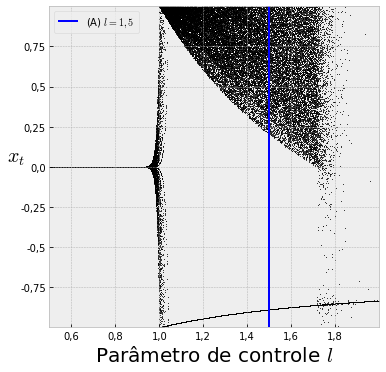

In [19]:
bif_picewise, fig_bif_picewise = bifurcacao_plot(
    f = linear_por_partes,
    xs_0 = np.linspace(-1,1.,50),
    n_iteracoes = 100,
    r = np.arange(0.5,2.,0.00001),
    titulo = '',
    figsize=(15,15),
    linhas_verticais= [1.5],
    labels_axis=('l','x_{t}')
    );


## Espectro de Lyapunov

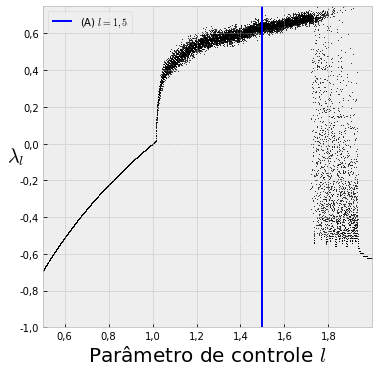

In [20]:
lyapu_picewise, fig_lyapu_picewise = expectro_lyapunov_plot(
    f = linear_por_partes,
    x_0 = 0.25,
    n_iteracoes = 100,
    r = np.arange(0.5,2.,0.0001, dtype=np.float64),
    titulo = '',
    figsize=(15,15),
    linhas_verticais= [1.5],
    labels_axis=('l','\lambda_{l}')
    );

                       

## Fixando l em $1.5$

In [21]:
from decimal import Decimal 
# parâmetros
p1 = Decimal(-0.5)
l = Decimal(1.5)
p2 = Decimal(-2.4)

# fuções lineares 


def f(x):
    x = float(x)
    l = float(l)
    
    f1 = lambda x : p1 * x + (p1 / l - 1) 
    f2 = lambda x : l * x 
    f3 = lambda x : p2 * x - (p2 / l - 1) 

    if -1 <= x < -1 / l:
        return f1(x)
    if -1 / l <= x < 1/l:
        return f2(x)
    if 1/l < x <= 1:
        return f3(x)

# Criando uma classe que vai conter a rede

In [22]:
class NonlocalCouplingNetwork():
    def __init__(self, ci, f, sigma, raio, tempo,
                 normalizar_matriz_rr=False, EPS = 0.03, FORTRAN = False):
        # Parametros da Rede
        self.__sigma = sigma
        self.__raio = raio
        self.__tempo = tempo
        self.__ci = ci
        self.__f = f

        #parametros da analise de quantificação de recorrência
        self.__normalizar_matriz_rr = normalizar_matriz_rr
        self.__EPS = EPS


        # criando um dataframe para armazenar os dados
        self.__rede = pd.DataFrame({},
                                   index=range(len(self.__ci)),
                                   dtype=np.float128)

        # Usando a iteração antiga como novas condições iniciais
        self.__rede[0] = self.__ci

        # Itera a rede
        if FORTRAN:
            self.__run_dynamic_fortran()
        else:
            self.__run_dynamic()
        # Velocidade
        self.__velocidade = self.__rede.diff(axis=1).iloc[:,1:]
        # Aceleracao
        self.__aceleracao = self.__velocidade.diff(axis=1).iloc[:,1:]

    def exec_recurrence_spatial_analysis(self, ti_map=1, tf_map=-1):
        self.__run_recurrence_spatial_analysis( ti_map, tf_map)

    def exec_recurrence_spatial_rate_analysis(self, ti_map=1, tf_map=-1):
        self.__run_recurrence_spatial_rate_analysis( ti_map,tf_map)


    # ================= Getters e Setters =============

    ## ================ Parametros de rede ============
    def get_sigma(self):
        """
        Retorna intensidade acoplamento sigma
        """
        return self.__sigma
    
    def get_raio(self):
        """
        Retorna raio de influencia dos elementos na rede
        """
        return self.__raio
    
    def get_tempo(self):
        """
        Retorna quantidade de tempos iterados
        """
        return self.__tempo

    ## Set para o fortran
    def __set_condicoes_iniciais_fortran(self):
        with open('condicoes_iniciais.dat', 'w') as arquivo:
            for i in self.__ci:
                arquivo.write(f'{i} ')

    def __set_parametros_rede(self):
        """
        Esta função define os parametros de rede 
        e salva num arquivo chamado 'tempo_sigma_raio.txt'
        para ser lido pelo fortran executar a rotina
        """  
        with open('parametros_rede.dat','w') as arquivo:
            arquivo.writelines(f'{self.__tempo}\n')
            arquivo.writelines(f'{self.__sigma}\n')
            arquivo.writelines(f'{self.__raio}\n')

    def __run_rotine_fortran(self):
        """
        Esta função compila e executa o código em fortran
        """
        ! gfortran "/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/fortran/linear_by_parts.f90" -o compilado.x
        ! ./compilado.x

    def __rede_fortran(self):
        """
        Atribui os dados mapa.dat como sendo o resultado da iteração da rede
        """
        self.__rede = pd.read_csv('/content/mapa.dat', sep='\s+', header=None).T


    ## ================= Redes ========================
    def get_spatial_temporal(self):
        """
        Retorna as posições nos tempos
        """
        return self.__rede
    
    def get_spatial_rate_temporal(self):
        """
        Retorna as velocidades nos tempos
        """
        return self.__velocidade


    ## ============= Análise de recorrência ===========
    
    def get_recurence_plot_spatial(self):
        """
        Retorna o objeto recurence plot posições
        """
        return self.__rp_spatial
    
    def get_recurence_plot_spatial_rate(self):
        """
        Retorna o objeto recurence plot velocidades
        """
        return self.__rp_spatial_rate

    
    def get_recurence_network_spatial(self):
        """
        Retorna o objeto recurence network das posições
        """
        return self.__rn_spatial

    def get_recurence_network_spatial_rate(self):
        """
        Retorna o objeto recurence network das velocidades
        """
        return self.__rn_spatial_rate


    def get_params_recurence_analysis_spatial(self):
        """
        Retorna parametros da analise de recorrencia da posição
        """
        return self.__params_ra_spatial

    def get_params_recurence_analysis_spatial_rate(self):
        """
        Retornaa parametros da analise de recorrencia da velocidade
        """
        return self.__params_ra_spatial_rate


    def get_matrix_recurrences_spatial(self):
        """
        Retorna um dicionario cuja chave é o tempo t de iteração
        e a chave é a matriz de recorrência da posição no tempo respectivo
        """
        return self.__matrix_recurrences_spatial

    def get_matrix_recurrences_spatial_rate(self):
        """
        Retorna um dicionario cuja chave é o tempo t de iteração
        e a chave é a matriz de recorrência da velocidade no tempo respectivo
        """
        return self.__matrix_recurrences_spatial_rate

    def get_spatial_matrices_bivariate_analysis(self):
        """
        Execute a função bivariate_analysis_spatial() antes deste get.
        - Retorna os autovalores, autovetores e os vetores de sinais das matrizes espaciais
        de acordo com a quantidade de k_autovetores selecionados na execução da 
        função bivariate_analysis_spatial

        return : autovalores, autovetores, vetor sinais
        """
        return self.__autovalores, self.__autovetores, self.__vetor_sinais

    def get_spatial_rate_matrices_bivariate_analysis(self):
        """
        Execute a função bivariate_analysis_spatial_rate() antes deste get.
        - Retorna os autovalores, autovetores e os vetores de sinais das matrizes da velocidade
        de acordo com a quantidade de k_autovetores selecionados na execução da 
        função bivariate_analysis_spatial
        """
        return self.__autovalores_velocidade, self.__autovetores_velocidade, self.__vetor_sinais_velocidade

    def describe_recurrence_analysis_spatial(self):
        """
        Retorna as estatisticas descritivas 
        dos parâmetros da analise de recorrência da posição
        """
        return self.__params_ra_spatial.describe()
    
    def describe_recurrence_analysis_spatial_rate(self):
        """
        Retorna as estatisticas descritivas 
        dos parâmetros da analise de recorrência da velocidade
        """
        return self.__params_ra_spatial_rate.describe()

    def dist_prob_lengths_spatial(self,):
        """
        Retorna um dicionario onde as chaves são as distribuições de probabilidade
        dos comprimentos na matriz de recorrência da posição.
        Cada valor é um DataFrame, cuja as colunas são as t-iterações

        prob_L = P(l)
        prob_V = P(v)
        prob_w = P(w)
        """
        return self.__dist_prob_comprimentos_spatial

    def dist_prob_lengths_spatial_rate(self,):
        """
        Retorna um dicionario onde as chaves são as distribuições de probabilidade
        dos comprimentos na matriz de recorrência da velocidade
        cada valor é um DataFrame, cuja as colunas são as t-iterações

        prob_L = P(l)
        prob_V = P(v)
        prob_w = P(w)
        """
        return self.__dist_prob_comprimentos_spatial_rate

    # ================= Métodos privados 

    ## ----------------- Funções de rede não local
    def __acoplamento_nao_local(self, posicoes_, posicao_, raio):
        """
        Calcula a distância entre a posição do indivíduo
        dentro do raio estipulado e retorna a distância.
        """
        self.__distancia = 0.0
        self.__i = int(posicao_)
        self.__P = int(self.__raio * len(posicoes_))
        for j in range(self.__i - self.__P, self.__i + self.__P):
            if j >= len(posicoes_):
                j = j - len(posicoes_)
            self.__distancia += posicoes_[j] - posicoes_[self.__i]

        return self.__distancia


    def __itera(self, f, x, sigma, raio):
        """
        Dada uma função f e um grupo de condições X
        Itera um passo a rede a partir de uma intensidade
        de acoplamento sigma e um raio de iteração.
        """
        #parametro vizinho
        self.__P = int(self.__raio * len(x))

        # atualiza os mapas
        self.__x = np.array([self.__f(i) for i in x])
        self.__xn = np.zeros_like(x)

        #Acoplamento
        for i in range(0, len(x)):
            self.__soma = self.__acoplamento_nao_local(self.__x, i, raio)
            self.__xn[i] = self.__x[i] + (self.__sigma / (2 * self.__P)) * self.__soma

        # Retorna o novo vetor
        return self.__xn

    def __recurrence_analysis(self, mapa):
        # Armazenar dados
        self.__params_recurence_analysis = {
        'Recurrence_rate':[],
        'Determinism':[],
        'Laminarity': [],
        'Average_diag_length':[],
        'Average_vert_length':[],
        'Average_white_vert_length':[],
        'Prob_l': [],
        'Prob_v': [],
        'Prob_w': [],
        'diag_entropy': [],
        'vert_entropy': [],
        'white_vert_entropy': [],
        'divergence_diag':[],
        'divergence_vert':[],
        'divergence_white_vert':[],
        #'Average_path_length' : [],
        #'Transitivity' : [],
        #'Global_clustering' : [],
        #'Assortativity' : []
        }

        # DataFrame para armazenar os valores dos parâmetros de recorrência
        self.__params_recurence_analysis = pd.DataFrame(
            self.__params_recurence_analysis, dtype = np.float64
            )

        # Dicionário para armazenar as matrizes de recorrência em cada iteração
        self.__matrix_recurrences = {}

        # Dicionários para armazenar as distribuições de probabilidade
        self.__prob_L = pd.DataFrame({})
        self.__prob_V = pd.DataFrame({})
        self.__prob_W = pd.DataFrame({})

        self.__entropy_diag = pd.DataFrame({})
        self.__entropy_vert = pd.DataFrame({})
        self.__entropy_white_vert = pd.DataFrame({})

        # Parametros RecurrencePlot
        DIM = 1  # Embedding dimension
        TAU = 0  # Embedding delay
        # Métricas disponíveis manhattan, euclidean, supremum
        METRIC = 'euclidean'

        for t in range(len(mapa.columns)):
            self.__rp = RecurrencePlot(mapa.iloc[:,t].to_numpy(),
                                       dim=DIM, tau=TAU, metric=METRIC,
                                       normalize=self.__normalizar_matriz_rr,
                                       threshold=self.__EPS)
            RR = self.__rp.recurrence_rate()
            DET = self.__rp.determinism(l_min=2)
            LAM = self.__rp.laminarity(v_min=2)
            DL = self.__rp.average_diaglength(l_min=2)
            TT = self.__rp.average_vertlength(v_min=2)
            TT_white = self.__rp.average_white_vertlength(w_min = 2)
            prob_l = self.__rp.diagline_dist()
            prob_v = self.__rp.vertline_dist()
            prob_w = self.__rp.white_vertline_dist()
            diag_entropy = self.__rp.diag_entropy()
            vert_entropy = self.__rp.vert_entropy()
            white_vert_entropy = self.__rp.white_vert_entropy()
            divergence_diag = 1 / (self.__rp.max_diaglength())
            divergence_vert = 1 / (self.__rp.max_vertlength())
            divergence_white_vert = 1 / (self.__rp.max_white_vertlength())

            self.__matrix_recurrences[t] = self.__rp.recurrence_matrix()


            self.__rn = RecurrenceNetwork(mapa.iloc[:,t].to_numpy(),
                                          dim=DIM, tau=TAU, metric=METRIC,
                                          normalize=self.__normalizar_matriz_rr,
                                          recurrence_rate=RR,
                                          threshold=self.__EPS
                                          )

            #L = self.__rn.average_path_length()
            #T = self.__rn.transitivity()
            #C = self.__rn.global_clustering()
            #R = self.__rn.assortativity()

            self.__params_recurence_analysis.loc[t, 'Recurrence_rate'] = RR
            self.__params_recurence_analysis.loc[t, 'Determinism'] = DET
            self.__params_recurence_analysis.loc[t, 'Laminarity'] = LAM
            self.__params_recurence_analysis.loc[t, 'Average_diag_length'] = DL
            self.__params_recurence_analysis.loc[t, 'Average_vert_length'] = TT
            self.__params_recurence_analysis.loc[t, 'Average_white_vert_length'] = TT_white
            self.__params_recurence_analysis.loc[t, 'Prob_l'] = str(prob_l)
            self.__params_recurence_analysis.loc[t, 'Prob_v'] = str(prob_v)
            self.__params_recurence_analysis.loc[t, 'Prob_w'] = str(prob_w)
            self.__params_recurence_analysis.loc[t, 'diag_entropy'] = diag_entropy
            self.__params_recurence_analysis.loc[t, 'vert_entropy'] = vert_entropy
            self.__params_recurence_analysis.loc[t, 'white_vert_entropy'] = white_vert_entropy
            self.__params_recurence_analysis.loc[t, 'divergence_diag'] = divergence_diag
            self.__params_recurence_analysis.loc[t, 'divergence_vert'] = divergence_vert
            self.__params_recurence_analysis.loc[t, 'divergence_white_vert'] = divergence_white_vert
            #self.__params_recurence_analysis.loc[t, 'Average_path_length'] = L
            #self.__params_recurence_analysis.loc[t, 'Transitivity'] = T
            #self.__params_recurence_analysis.loc[t, 'Global_clustering'] = C
            #self.__params_recurence_analysis.loc[t, 'Assortativity'] = R

            ### ATENÇÃO: ADICIONARL UM NP.MEAN(PROB_L/V/W)
            #self.__prob_L[t] = prob_l
            #self.__prob_V[t] = prob_v
            #self.__prob_W[t] = prob_w

            self.__entropy_diag[t] = [self.__rp.diag_entropy(k) for k in range(100)]
            self.__entropy_vert[t] = [self.__rp.vert_entropy(k) for k in range(100)]
            self.__entropy_white_vert[t] = [self.__rp.white_vert_entropy(k) for k in range(100)]

        self.__dist_prob_comprimentos = {'prob_L' : self.__prob_L,
                                         'prob_V' : self.__prob_V,
                                         'prob_W' : self.__prob_W,
                                         'entropy_diag': self.__entropy_diag,
                                         'entropy_vert': self.__entropy_vert,
                                         'entropy_white_vert': self.__entropy_white_vert,
                                         }
        # Limpando output
        IPythonNB.clear_output(wait=False)
        return self.__params_recurence_analysis, self.__matrix_recurrences, self.__rp, self.__rn, self.__dist_prob_comprimentos

    def bivariate_analysis(self, matriz_recorrencia, k_autovetores = 0):
        """
        Calcula os autovalores e autovetores de uma matriz de recorrência espacial

        - Se k_autovetores = 0 realiza a soma de todos os autovetores cujo autovalores
        são maiores que 1.
        - Se k_autovetores = 5, soma os 5 autovetores cujo autovalores
        são maiores que 1.

        return: autovals, autovec, sign_vec
        """
        #autovalores, autovetores = la.eigh(matriz_recorrencia, driver='evd', lower=True)
        autovalores, autovetores = la.eigh(matriz_recorrencia, driver='evd', lower=False)
        autovalores_sr = pd.Series(np.round(autovalores,4))
        autovetores_df = pd.DataFrame(np.round(autovetores,4))

        if k_autovetores != 0:
            autovalores_selecionados = autovalores_sr[autovalores_sr > 1.].sort_values()
            k_autovalores_selecionados = autovalores_selecionados.iloc[-k_autovetores:]
            indice = k_autovalores_selecionados.index
            autovetores_selecionados = autovetores_df[indice].T
            soma_autovetores_selecionados = abs(autovetores_df[indice].T).sum()
            vetor_sinais = np.array([1 if x > 0 else 0 for x in soma_autovetores_selecionados])

            return autovalores_sr, autovetores_selecionados, vetor_sinais
        else:
            autovalores_selecionados = autovalores_sr[autovalores_sr > 1.]
            indice = autovalores_selecionados.index
            autovetores_selecionados = autovetores_df[indice].T
            soma_autovetores_selecionados = abs(autovetores_df[indice].T).sum()
            vetor_sinais = np.array([1 if x > 0 else 0 for x in soma_autovetores_selecionados])

            return autovalores_sr, autovetores_selecionados, vetor_sinais


    def __bivariate_analysis(self, matriz_recorrencia, k_autovetores = 0):
        """
        Calcula os autovalores e autovetores de uma matriz de recorrência espacial

        - Se k_autovetores = 0 realiza a soma de todos os autovetores cujo autovalores
        são maiores que 1.
        - Se k_autovetores = 5, soma os 5 autovetores cujo autovalores
        são maiores que 1.
        """
        #autovalores, autovetores = la.eigh(matriz_recorrencia, driver='evd', lower=True)
        autovalores, autovetores = la.eigh(matriz_recorrencia, driver='evd', lower=False)
        autovalores_sr = pd.Series(np.round(autovalores,4))
        autovetores_df = pd.DataFrame(np.round(autovetores,4))

        if k_autovetores != 0:
            autovalores_selecionados = autovalores_sr[autovalores_sr > 1.]
            k_autovalores_selecionados = autovalores_selecionados.iloc[-k_autovetores:]
            indice = k_autovalores_selecionados.index
            autovetores_selecionados = abs(autovetores_df[indice].T).sum()
            vetor_sinais = np.array([1 if x > 0 else 0 for x in autovetores_selecionados])

            return autovalores_sr, autovetores_selecionados, vetor_sinais
        else:
            autovalores_selecionados = autovalores_sr[autovalores_sr > 1.]
            indice = autovalores_selecionados.index
            autovetores_selecionados = abs(autovetores_df[indice].T).sum()
            vetor_sinais = np.array([1 if x > 0 else 0 for x in autovetores_selecionados])

            return autovalores_sr, autovetores_selecionados, vetor_sinais        

    def bivariate_analysis_spatial(self, k_autovetores):
        """
        É importante ter executado a função exec_recurrence_spatial_analysis()
        antes de excutar esta função.
        Realiza o cálculo dos autovalores e autovetores das matrizes de recorrência
        O vetor de sinais é a soma dos k primeiros autovetores no espectro de autovetores.

        :: return autovalores, autovetores, vetor_sinais 
        """
        autovalores = {}
        autovetores = {}
        vetor_sinais = {}

        for iteracao in self.get_matrix_recurrences_spatial().keys():
            autoval, autovet, vetor_s = self.__bivariate_analysis(self.get_matrix_recurrences_spatial()[iteracao],k_autovetores)

            autovalores[iteracao] = autoval
            autovetores[iteracao] = autovet
            vetor_sinais[iteracao] = vetor_s
        
        self.__autovalores = pd.DataFrame(autovalores)
        self.__autovetores = pd.DataFrame(autovetores)
        self.__vetor_sinais = pd.DataFrame(vetor_sinais)

        return self.__autovalores, self.__autovetores, self.__vetor_sinais

    def bivariate_analysis_spatial_rate(self, k_autovetores):
        """
        É importante ter executado a função exec_recurrence_spatial_analysis()
        antes de excutar esta função.
        Realiza o cáluclo dos autovalores e autovetores das matrizes de recorrência
        O vetor de sinais é a soma dos k primeiros autovetores no espectro de autovetores.

        :: return autovalores, autovetores, vetor_sinais 
        """
        autovalores = {}
        autovetores = {}
        vetor_sinais = {}

        for iteracao in self.get_matrix_recurrences_spatial().keys():
            autoval, autovet, vetor_s = self.bivariate_analysis(self.get_matrix_recurrences_spatial_rate()[iteracao],k_autovetores)

            autovalores[iteracao] = autoval
            autovetores[iteracao] = autovet
            vetor_sinais[iteracao] = vetor_s

        self.__autovalores_velocidade = pd.DataFrame(autovalores)
        self.__autovetores_velocidade = pd.DataFrame(autovetores)
        self.__vetor_sinais_velocidade = pd.DataFrame(vetor_sinais)

        return self.__autovalores_velocidade, self.__autovetores_velocidade, self.__vetor_sinais_velocidade


    def __run_dynamic(self):
        """
        Função que itera mapa. Recebe um vetor com as CI
        Itera em t_iterações a rede com intensidade sigma e raio r
        Retorna uma tabela com os dados iterados
        """
        # Iterando a rede
        for t in range(self.__tempo):
            self.__rede[t+1] = self.__itera(self.__f, self.__rede[t], self.__sigma, self.__raio)

    def __run_dynamic_fortran(self):
        self.__set_condicoes_iniciais_fortran()
        self.__set_parametros_rede()
        self.__run_rotine_fortran()
        self.__rede_fortran()

    def __run_recurrence_spatial_analysis(self, ti_map, tf_map):
        self.__params_ra_spatial, self.__matrix_recurrences_spatial, self.__rp_spatial, self.__rn_spatial, self.__dist_prob_comprimentos_spatial = self.__recurrence_analysis(self.__rede.iloc[:,ti_map:tf_map])
        return self.__params_ra_spatial, self.__matrix_recurrences_spatial, self.__rp_spatial, self.__rn_spatial, self.__dist_prob_comprimentos_spatial

    def __run_recurrence_spatial_rate_analysis(self, ti_map, tf_map):
        self.__params_ra_spatial_rate, self.__matrix_recurrences_spatial_rate, self.__rp_spatial_rate, self.__rn_spatial_rate, self.__dist_prob_comprimentos_spatial_rate = self.__recurrence_analysis(self.__velocidade.iloc[:,ti_map:tf_map])
        return self.__params_ra_spatial_rate, self.__matrix_recurrences_spatial_rate, self.__rp_spatial_rate, self.__rn_spatial_rate, self.__dist_prob_comprimentos_spatial_rate

    # ================= Métodos de exibição 

    ## ---------------- Posição
    def plot_spatial_temporal(self, ti_map=-20, tf_map=-1, t_sp = -1, periodo = None, vmin_map=None, vmax_map=None, cmap='jet'):
        """
        Exibe um plot da evolução espacial da rede.

        Os parametros "ti_map" e "tf_map" servem para escolher o range
        de exibição do mapa espaço-temporal.

        O parâmetro "t_sp" é o tempo da disposição espacial dos elementos.
        """
        caracteristica_rede = f'$\sigma = {self.__sigma}$ \t $r={self.__raio}$\n'

        spatial_temporal, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))

        sns.scatterplot(x = self.__rede.iloc[:,t_sp].index,
                        y = self.__rede.iloc[:,t_sp], ax=ax1)
        ax1.set_title('Arranjo espacial dos elementos\n na ultima iteração',
                    fontsize=20, pad=30)
        ax1.set_xlabel('Elemento $i$', fontsize=18)
        ax1.set_ylabel('Posição $X_{t}^{i}$', fontsize=18)
        ax1.set(ylim=(vmin_map, vmax_map))

        if periodo:
            iteracoes_selecionadas = np.arange(1, self.__tempo, periodo)
            sns.heatmap(self.__rede[iteracoes_selecionadas].iloc[:,ti_map:tf_map].T[::-1], ax=ax2,
                        cmap=cmap, vmin=vmin_map, vmax=vmax_map, 
                        cbar_kws={"format": formatador})
        else:
            sns.heatmap(self.__rede.iloc[:,ti_map:tf_map].T[::-1], ax=ax2,
                        cmap=cmap, vmin=vmin_map, vmax=vmax_map, 
                        cbar_kws={"format": formatador})
        ax2.set_title(f'Evolução espaço temporal \n{caracteristica_rede}')
        ax2.set_ylabel('Iteração $t$', fontsize=18)
        ax2.set_xlabel('Elemento $X^i$', fontsize=18)

        # Formatando os pontos pra vírgula
        ax1.yaxis.set_major_formatter(formatador)

        return spatial_temporal

    def plot_spatial_rate_temporal(self, ti_map=-20, tf_map=-1, t_sp = -1,
                                    periodo = None, vmin_map=None, vmax_map=None, cmap='hot'):
        """
        Exibe um plot da evolução da velocidade da rede.

        Os parametros "ti_map" e "tf_map" servem para escolher o range
        de exibição do mapa espaço-temporal.

        O parâmetro "t_sp" é o tempo da disposição espacial dos elementos.
        """
        caracteristica_rede = f'$\sigma = {self.__sigma}$ \t $r={self.__raio}$\n'

        rate_spatial_rate_temporal, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
        rate_spatial_rate_temporal.tight_layout(pad=2.1)

        sns.scatterplot(x = self.__velocidade.iloc[:,t_sp].index,
                        y = self.__velocidade.iloc[:,t_sp],
                        color='darkorange', ax=ax1)
        
        ax1.set_title(f'Arranjo da velocidade dos elementos\n na iteração {t_sp}',
                    fontsize=20, pad=30)
        ax1.set_xlabel('Elemento $i$', fontsize=18)
        ax1.set_ylabel('Velocidade $\Delta X_{t}^{i}$', fontsize=18)
        ax1.set(ylim=(vmin_map, vmax_map))

        if periodo:
            iteracoes_selecionadas = np.arange(1, self.__tempo, periodo)
            sns.heatmap(self.__velocidade[iteracoes_selecionadas].iloc[:,ti_map:tf_map].T[::-1], ax=ax2,
                        cmap=cmap,  vmin=vmin_map, vmax=vmax_map, 
                        cbar_kws={"format": formatador})
        else:
            sns.heatmap(self.__velocidade.iloc[:,ti_map : tf_map].iloc[:,ti_map:tf_map].T[::-1], ax=ax2,
                        cmap=cmap,  vmin=vmin_map, vmax=vmax_map, 
                        cbar_kws={"format": formatador})
        ax2.set_title(f'Velocidade no tempo \n{caracteristica_rede}')
        ax2.set_ylabel('Iteração $t$', fontsize=18)
        ax2.set_xlabel('Velocidade $\Delta X^i$', fontsize=18)

        ax = (ax1,ax2)
        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)

        return rate_spatial_rate_temporal


    def plot_recurrence_matrix_spatial(self, params_recurrence_analysis,
                                       iteracao_ra, ti_ra=0, tf_ra=-1,
                                       palette_color = 'Set1', MMA=None):
        """
        Recebe uma lista de parâmetros da analise de recorrencia (lista)
        e exibe a evolução desse parametro nas iterações 
        e a matriz de recorrência na ultima iteração.

        Através da variável "iteracao_ra" é possível escolher a matriz de recorrência numa
        iteração especifica

        As variaveis "ti_ra" e "tf_ra" servem para delimitar a exibição dos
        parametros de recorrência num período especifico.

        retorna a figura
        """

        caracteristica_rede = f'$\sigma = {self.__sigma}$ \t $r={self.__raio}$\n'

        if MMA:
            parametros_rqa = self.__params_ra_spatial[params_recurrence_analysis].rolling(window=MMA).mean().iloc[MMA:, :]
        else:
            parametros_rqa = self.__params_ra_spatial[params_recurrence_analysis]


        # Cria figura
        recurrence_matrix_spatial, (ax1, ax2) = plt.subplots(nrows=1,
                                                             ncols=2,
                                                             figsize=(15,6))
        self.__palette_color = palette_color
        for param in params_recurrence_analysis:
            if param in self.__params_ra_spatial.columns:
                sns.lineplot(data = parametros_rqa.iloc[ti_ra : tf_ra],
                             x = parametros_rqa.iloc[ti_ra : tf_ra].index,
                             y = f'{str(param)}',
                             label=f'{str(param).replace("_"," ").title()}',
                             linewidth=0.7, palette = self.__palette_color, ax=ax1)
            else:
                raise ValueError(f'Escolha um ou mais dos parametros de Análise de Recorrência:\n{self.__params_ra_spatial_rate.columns}')

        titulo_ax1 = 'Evolução dos parâmetros \n de recorrência $X^i$\n'
        ax1.set_title(titulo_ax1 + caracteristica_rede, fontsize=20, pad=30)
        ax1.set_xlabel('Iteração $t$', fontsize=18)
        ax1.set_ylabel('Valor do parâmetro de $X_{t}^{i}$', fontsize=18)
        ax1.set(ylim=(0, 1.))
        # Formatando os pontos pra vírgula
        ax1.yaxis.set_major_formatter(formatador)

        # Segundo eixo
        self.__iteracao = int(iteracao_ra)
        img = ax2.matshow(self.__matrix_recurrences_spatial[self.__iteracao],
                          vmin=0, vmax=1, cmap='binary')
        
        ax2.set_ylabel(r'$ X_{t}^{i}$',fontsize=18)
        ax2.set_xlabel(r'$ X_{t}^{j}$',fontsize=18)

        # Aspectos eixo 2
        caracteristica_mapa_rr = f'\n$\epsilon = {self.__EPS}$'
        titulo_ax2 = f'Recorrência espacial na iteração {self.__iteracao}'
        ax2.set_title(titulo_ax2 + caracteristica_mapa_rr,
                      fontsize=20, pad=20)
        cbar_ax = recurrence_matrix_spatial.add_axes([.90, 0.10, 0.01, 0.8]) 
        recurrence_matrix_spatial.colorbar(img, cax=cbar_ax,
                                           label='Valor Matriz Recorrência')
        return recurrence_matrix_spatial

    def plot_recurrence_matrix_spatial_rate(self, params_recurrence_analysis,
                                            iteracao_ra, ti_ra = 0, tf_ra = -1,
                                            palette_color = 'Set1', MMA = None):
        """
        Recebe uma lista de parâmetros da analise de recorrencia (lista)
        e exibe a evolução desse parametro nas iterações 
        e a matriz de recorrência na ultima iteração.

        Através da variável "iteracao_ra" é possível escolher a matriz de recorrência numa
        iteração especifica

        As variaveis "ti_ra" e "tf_ra" servem para delimitar a exibição dos
        parametros de recorrência num período especifico.

        retorna a figura
        """

        caracteristica_rede = f'\n $\sigma = {self.__sigma}$ \t $r={self.__raio}$'

        if MMA:
            parametros_rqa = self.__params_ra_spatial_rate[params_recurrence_analysis].rolling(window=MMA).mean().iloc[MMA:, :]
        else:
            parametros_rqa = self.__params_ra_spatial_rate[params_recurrence_analysis]

        # Cria figura
        recurrence_matrix_spatial_rate, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,
                                                             figsize=(15,6))
        self.__colors = list(mcolors.BASE_COLORS)
        for cor, param in enumerate(params_recurrence_analysis):
            if param in self.__params_ra_spatial_rate.columns:
                sns.lineplot(data = parametros_rqa.iloc[ti_ra : tf_ra],
                             x = parametros_rqa.iloc[ti_ra : tf_ra].index,
                             y = f'{str(param)}',
                             label=f'{str(param).replace("_"," ").title()}',
                             linewidth=0.7, color = self.__colors[cor], ax=ax1)
            else:
                raise ValueError(f'Escolha um ou mais dos parametros de Análise de Recorrência:\n{self.__params_ra_spatial_rate.columns}')

        titulo_ax1 = r'Evolução dos parâmetros de recorrência $\Delta X^i$'
        ax1.set_title(titulo_ax1 + caracteristica_rede,
                      fontsize=20, pad=30)
        ax1.set_xlabel('Iteração $t$', fontsize=18)
        ax1.set_ylabel('Valor do parâmetro de $\Delta X_{t}^{i}$', fontsize=18)
        ax1.set(ylim=(0, None))

        # Segundo eixo
        self.__iteracao = int(iteracao_ra)
        img = ax2.matshow(self.__matrix_recurrences_spatial_rate[self.__iteracao],
                          vmin=0, vmax=1, cmap='YlOrBr')
        
        ax2.set_ylabel(r'$\Delta X_{t}^{i}$',fontsize=18)
        ax2.set_xlabel(r'$\Delta X_{t}^{j}$',fontsize=18)

        # Aspectos eixo 2
        caracteristica_mapa_rr = f'\n$\epsilon = {self.__EPS}$'
        titulo_ax2 = f'Recorrência espacial na iteração {self.__iteracao}'
        ax2.set_title(titulo_ax2 + caracteristica_mapa_rr,fontsize=20, pad=20)
        cbar_ax = recurrence_matrix_spatial_rate.add_axes([.90, 0.10, 0.02, 0.8])
        recurrence_matrix_spatial_rate.colorbar(img, cax=cbar_ax,
                                                label='Valor Matriz Recorrência')

        ax = (ax1,ax2)
        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)

        return recurrence_matrix_spatial_rate

    
    def plot_param_ra_spatial(self, params_recurrence_analysis,
                              ti_ra=0, tf_ra =-1, ti_map = -20, tf_map = -1,
                              vmin_map=None, vmax_map=None,
                              palette_color = 'Set1'):
        caracteristica_rede = f'$\sigma = {self.__sigma}$ \t $r={self.__raio}$\n'

        param_ra_spatial, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))

        self.__palette_color = palette_color
        self.__params_recurrence_analysis = params_recurrence_analysis
        for param in self.__params_recurrence_analysis:
            if param in self.__params_ra_spatial.columns:
                sns.lineplot(data = self.__params_ra_spatial.iloc[ti_ra : tf_ra],
                             x = self.__params_ra_spatial.iloc[ti_ra : tf_ra].index,
                             y = f'{str(param)}',
                             label=f'{str(param).replace("_"," ").title()}',
                             palette= self.__palette_color, ax=ax1)
            else:
                raise ValueError(f'Escolha um ou mais dos parametros de Análise de Recorrência:\n{self.__params_ra_spatial.columns}')

        ax1.set_title('Evolução paramétrica de recorrência de $X^i$',
                    fontsize=20, pad=30)
        ax1.set_xlabel('Iteração $t$', fontsize=18)
        ax1.set_ylabel('Valor do parâmetro de $X_{t}^{i}$', fontsize=18)
        ax1.set(ylim=(0, None))

        sns.heatmap(self.__rede.iloc[:,ti_map : tf_map], ax=ax2, cmap='jet', vmin=vmin_map, vmax=vmax_map)
        ax2.set_title(f'Evolução espaço temporal \n{caracteristica_rede}')
        ax2.set_xlabel('Iteração $t$', fontsize=18)
        ax2.set_ylabel('Elemento $X^i$', fontsize=18)

        ax = (ax1,ax2)
        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)


        return param_ra_spatial

    def plot_param_ra_spatial_rate(self, params_recurrence_analysis,
                                   ti_ra=0, tf_ra=-1, ti_map = -20, tf_map = -1,
                                   vmin_map=None, vmax_map=None,
                                   palette_color = 'Set1'):
        caracteristica_rede = f'$\sigma = {self.__sigma}$ \t $r={self.__raio}$\n'

        param_ra_spatial_rate, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
        self.__colors = list(mcolors.BASE_COLORS)
        self.__params_recurrence_analysis = params_recurrence_analysis
        for cor, param in enumerate(self.__params_recurrence_analysis):
            if param in self.__params_ra_spatial_rate.columns:
                sns.lineplot(data = self.__params_ra_spatial_rate.iloc[ti_ra : tf_ra],
                             x = self.__params_ra_spatial_rate.iloc[ti_ra : tf_ra].index,
                             y = f'{str(param)}',
                             label=f'{str(param).replace("_"," ").title()}',
                             color = self.__colors[cor], ax=ax1)
            else:
                raise ValueError(f'Escolha um ou mais dos parametros de Análise de Recorrência:\n{self.__params_ra_spatial_rate.columns}')

        ax1.set_title('Evolução paramétrica \n da recorrência de $\Delta X^i$',
                    fontsize=20, pad=30)
        ax1.set_xlabel('Elemento $i$', fontsize=18)
        ax1.set_ylabel('Valor do parâmetro de $\Delta X_{t}^{i}$', fontsize=18)
        ax1.set(ylim=(0, None))

        sns.heatmap(self.__velocidade.iloc[:,ti_map : tf_map], ax=ax2,
                    cmap='gist_heat', vmin=vmin_map, vmax=vmax_map)
        ax2.set_title(f'Evolução temporal da velocidade \n{caracteristica_rede}')
        ax2.set_xlabel('Iteração $t$', fontsize=18)
        ax2.set_ylabel('$\Delta$ do elemento $X^i$', fontsize=18)

        ax = (ax1,ax2)
        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)

        return param_ra_spatial_rate


    def plot_dist_prob_lengths_temporal(self, dist_prob_lengths, normalize,
                                        ti_map = 0, tf_map = -1):
        """
        Recebe uma lista 'dist_prob_lengths' com os rótulos das distribuições,
        que no caso as únicas são: ['prob_L','prob_V', 'prob_W'].

        Retorna uma figura.
        """

        figure_dist_prob_lengths, axes = plt.subplots(nrows=len(dist_prob_lengths), ncols=2,
                                               figsize=(len(dist_prob_lengths) * 6.2,
                                                        len(dist_prob_lengths) * 5))
        for linha, distribuicao in enumerate(dist_prob_lengths):
            if distribuicao in self.__dist_prob_comprimentos_spatial.keys():
                if normalize == 'MinMaxScaler':
                    scaler = MinMaxScaler()
                    spatial_prob = scaler.fit_transform(self.__dist_prob_comprimentos_spatial[distribuicao])
                    spatial_rate_prob = scaler.fit_transform(self.__dist_prob_comprimentos_spatial_rate[distribuicao])
                elif normalize == "StandardScaler":
                    scaler = StandardScaler()
                    spatial_prob = scaler.fit_transform(self.__dist_prob_comprimentos_spatial[distribuicao])
                    spatial_rate_prob = scaler.fit_transform(self.__dist_prob_comprimentos_spatial_rate[distribuicao])
                elif normalize == None:
                    spatial_prob = self.__dist_prob_comprimentos_spatial[distribuicao].to_numpy()
                    spatial_rate_prob = self.__dist_prob_comprimentos_spatial_rate[distribuicao].to_numpy()

                else:
                    raise ValueError('Escolha uma das normalizações: ["MinMaxScaler","StandardScaler","None"]')

                sns.heatmap(spatial_prob[:,ti_map : tf_map], cmap='jet', ax=axes[linha][0])
                hmap = sns.heatmap(spatial_rate_prob[:,ti_map : tf_map], cmap='jet', ax=axes[linha][1],
                            cbar_kws={'label': f'$P({str(distribuicao[-1]).lower()})$'})
                hmap.figure.axes[-1].yaxis.label.set_size(20)

                axes[linha][0].set_ylabel('Alcance')
            else:
                raise ValueError(f'Escolha uma distribuição entre as: {self.__dist_prob_comprimentos_spatial.keys()}')

        axes[0][0].set_title('Spatial', pad=20)
        axes[0][1].set_title('Spatial Rate', pad=20)
        axes[linha][0].set_xlabel('iteração $t$')
        axes[linha][1].set_xlabel('iteração $t$')
        

        figure_dist_prob_lengths.suptitle('Distribuição de frequência dos comprimentos em cada iteração')
        return figure_dist_prob_lengths

    def plot_mapa_sptial_rate_with_rqa_params(self, parametros_rr, ti_map = 0, tf_map = -1, MMA=1, vmin_map=None, vmax_map=None,):
        for parametro in parametros_rr:
            if parametro not in self.__params_ra_spatial_rate.columns:
                raise ValueError(f"O {parametro} não esta em {self.__params_ra_spatial_rate().columns}")

        parametros_rr.insert(0,0)

        def format_axes(fig):
            for i, ax in enumerate(fig.axes):
                #ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
                ax.tick_params(labelbottom=True, labelleft=True)
                ax.set_title(f'{str(parametros_rr[i]).replace("_"," ").title()}', fontsize=20, pad=10)
                ax.set_ylabel('')
        
        fig = plt.figure(constrained_layout=True, figsize=(15,8))
        
        gs = GridSpec(3, 3, figure=fig)
        ax1 = fig.add_subplot(gs[:, :2])
        # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
        ax2 = fig.add_subplot(gs[0, 2:])
        ax3 = fig.add_subplot(gs[1, 2:])
        ax4 = fig.add_subplot(gs[2, 2:])
        
        ax = (ax1,ax2,ax3,ax4)
        cores = list(mcolors.BASE_COLORS)
        i = 1
        for parametro in parametros_rr[1:]:
            if parametro in self.__params_ra_spatial_rate.columns:
                sns.lineplot(data = self.__params_ra_spatial_rate.rolling(MMA).mean()[parametro].iloc[ti_map:tf_map],
                             ax = ax[i], color=cores[i-1])
                i+=1
        
        fig.suptitle('Evolução da velocidade $\Delta X_{t}^{i}$')
        format_axes(fig)
        
        sns.heatmap(data = self.__velocidade.iloc[:,ti_map : tf_map],
                    cmap='hot', ax=ax1, vmin=vmin_map, vmax=vmax_map)
        ax1.set_title(f'$\sigma = {self.__sigma}$ \t $r = {self.__raio}$', pad=20)
        ax1.set_ylabel('$\Delta X_{t}^{i}$')
        ax1.set_xlabel('Iteração $t$')
        ax4.set_xlabel('Iteração $t$')
        plt.show()

        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)

        return fig


    def plot_spatial_rate_temporal_recurrence_matrix(self, iteracao_ra, t_sp = -1, vmin_map=None, vmax_map=None):

        caracteristica_rede = f'$\sigma = {self.__sigma}$ \t $r={self.__raio}$\n'

        rate_spatial_rate_temporal, ax = plt.subplots(1,2, figsize=(15,6))

        # Primeiro Eixo
        sns.scatterplot(x = self.__velocidade.iloc[:,t_sp].index,
                        y = self.__velocidade.iloc[:,t_sp],
                        color='darkorange', ax=ax[0])
        # Aspectos eixo 1
        ax[0].set_title(f'Arranjo da velocidade dos elementos\n na iteração {t_sp}',
                    fontsize=20, pad=30)
        ax[0].set_xlabel('Elemento $i$', fontsize=18)
        ax[0].set_ylabel('Velocidade $\Delta X_{t}^{i}$', fontsize=18)
        ax[0].set(ylim=(vmin_map, vmax_map))

        # Segundo eixo
        self.__iteracao = int(iteracao_ra)
        img = ax[1].matshow(self.__matrix_recurrences_spatial_rate[self.__iteracao],
                          vmin=0, vmax=1, cmap='YlOrBr')
        
        ax[1].set_ylabel(r'$\Delta X_{t}^{i}$',fontsize=18)
        ax[1].set_xlabel(r'$\Delta X_{t}^{j}$',fontsize=18)

        # Aspectos eixo 2
        caracteristica_mapa_rr = f'\n$\epsilon = {self.__EPS}$'
        titulo_ax1 = f'Recorrência espacial na iteração {self.__iteracao}'
        ax[1].set_title(titulo_ax1 + caracteristica_mapa_rr,fontsize=20, pad=20)
        cbar_ax = rate_spatial_rate_temporal.add_axes([.90, 0.10, 0.02, 0.8])
        rate_spatial_rate_temporal.colorbar(img, cax=cbar_ax,
                                            label='Valor Matriz Recorrência')
        
        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)

        return rate_spatial_rate_temporal

    def plot_bivariate_analysis_spatial(self, iteracao, k_autovetores=0, cmap='binary'):
        """
        Precisa executar a função exec_recurrence_spatial_analysis() primeiro.
        A iteração é de acordo com a iteração escolhida na função exec_recurrence_spatial_analysis()
        
        """

        # W: Autovalores associados a matrix_recorrencia
        # V: Autovetores cujo autovalor é maior que 1
        # S: Vetores sinais, soma dos módulos das componentes de V
        w, v, s = self.bivariate_analysis(self.__matrix_recurrences_spatial[iteracao], k_autovetores)

        fig_bivariate_analysis, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
        fig_bivariate_analysis.tight_layout(pad=1.5)

        sns.heatmap(data = self.__matrix_recurrences_spatial[iteracao].T[::-1], cmap=cmap, ax=ax[0])
        sns.scatterplot(data = w,color='red', ax=ax[1])
        sns.scatterplot(data = v,color='blue', ax=ax[2])
        sns.scatterplot(data = s,color='green', ax=ax[3],
                        label=f'C = {sum(s)}')
        ax[3].set_ylim(-0.05,None)
        ax[2].set_ylim(-0.05,None)
    
        ax[0].set_title('Matriz', fontsize=20,pad=20)
        ax[1].set_title(r'Autovalores: $\lambda > 1$', fontsize=20,pad=20)
        ax[2].set_title(r'Autovetor: $\vec{V} = \sum_{k}^{N}{|v_k|}$', fontsize=20,pad=20)
        ax[3].set_title(r'Vetor de Sinais: $\vec{S} = Sign(\vec{V})$',fontsize=20,pad=20)

        for axis in ax:
            # Formatando os pontos pra vírgula
            axis.yaxis.set_major_formatter(formatador)
            axis.xaxis.set_major_formatter(formatador)

        return fig_bivariate_analysis

    def plot_bivariate_analysis_spatial_temporal(self, periodo=1, cmap='jet'):
        
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25,5))
        fig.tight_layout(pad=1.5)
        tamanho = len(self.get_matrix_recurrences_spatial()) + 1
        periodos = np.arange(1, len(self.__autovalores), periodo)

        sns.heatmap(data = self.__rede.iloc[:,-tamanho:].iloc[:,periodos].T[::-1], ax=ax[0],
                    cmap=cmap, cbar_kws={'label': r'$X_i$'})
        sns.heatmap(data = self.__autovalores[periodos].T[::-1], ax=ax[1], cmap='jet')
        sns.heatmap(data = self.__autovetores[periodos].T[::-1], ax=ax[2], cmap='jet')
        sns.heatmap(data = self.__vetor_sinais[periodos].T[::-1], ax=ax[3], cmap='binary', vmin=0, vmax=1)

        ax[0].set_title('Evolução espaço-temporal', pad=20)
        ax[1].set_title(r'Autovalores $\lambda$', pad=20)
        ax[2].set_title(r'Autovetores |$\vec{V}$|', pad=20)
        ax[3].set_title(r'Vetor de Sinais $\vec{S}$', pad=20)

        ax[0].set_ylabel('Iteração $t$')
        for i in range(4):
            ax[i].set_xlabel('$X_i$')

        fig.suptitle(f'Parâmetros de algebra linear da matriz de recorrência da evolução espaço-temporal $\sigma = {self.__sigma}$', y=1.09)
        return fig

    def plot_bivariate_analysis_spatial_rate_temporal(self, periodo=1, cmap='hot'):
        
        fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(25,5))
        fig.tight_layout(pad=1.5)
        tamanho = len(self.get_matrix_recurrences_spatial_rate()) + 1

        #periodos = np.arange(1, len(self.__autovalores_velocidade), periodo)

        sns.heatmap(data = self.__velocidade.iloc[:,-tamanho:].T[::-1], ax=ax[0],
                    cmap=cmap, cbar_kws={'label': r'$\Delta X_i$'})
        sns.heatmap(data = self.__autovalores_velocidade.T[::-1], ax=ax[1], cmap='gnuplot')
        sns.heatmap(data = self.__autovetores_velocidade.T[::-1], ax=ax[2], cmap='gnuplot')
        sns.heatmap(data = self.__vetor_sinais_velocidade.T[::-1], ax=ax[3], cmap='binary', vmin=0, vmax=1)

        ax[0].set_title('Evolução da Velocidade Espaço-temporal', pad=20)
        ax[1].set_title(r'Autovalores $\lambda$', pad=20)
        ax[2].set_title(r'Autovetores |$\vec{V}$|', pad=20)
        ax[3].set_title(r'Vetor de Sinais $\vec{S}$', pad=20)

        ax[0].set_ylabel('Iteração $t$')
        for i in range(4):
            ax[i].set_xlabel('$\Delta X_i$')
    
        fig.suptitle(f'Parâmetros de algebra linear da matriz de recorrência da velocidade da evolução espaço-temporal $\sigma = {self.__sigma}$', y=1.09)

        return fig
    


#Instanciando as redes 


## Definindo as condições iniciais

### Aleatórias

In [23]:
# semente = 1458513866
np.random.seed(semente) 

# Testando outra semente
#np.random.seed(1458513861)
x = np.random.random(100)

condicoes_aleatorias = pd.Series(2*x-1)
condicoes_aleatorias

condicoes_senoidais = np.array([np.sin((i*2*np.pi)/(100)) for i in range(100)])
condicoes_cossenoidais = np.array([np.cos((i*2*np.pi)/(100)) for i in range(100)])

condicoes_senoidais_inv = np.array([-1*np.sin((i*2*np.pi)/(100)) for i in range(100)])
condicoes_cossenoidais_inv = np.array([-1*np.cos((i*2*np.pi)/(100)) for i in range(100)])

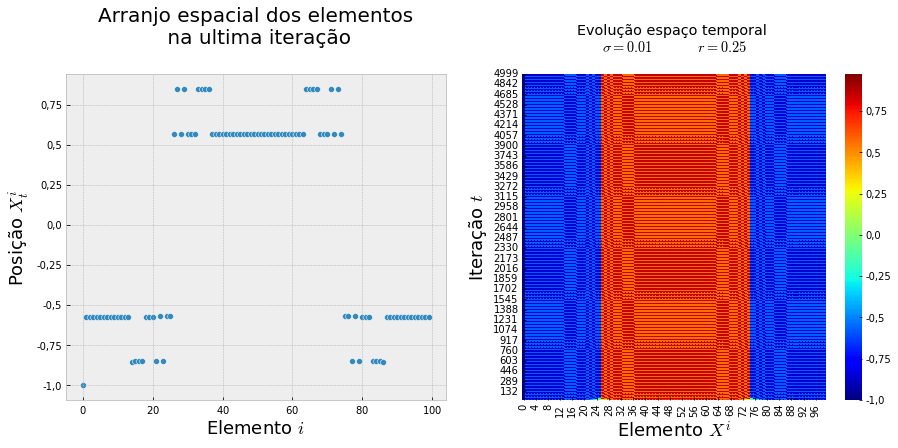

In [24]:
rede_geradora_condicoes_iniciais = NonlocalCouplingNetwork(condicoes_cossenoidais_inv, f, sigma=0.01, raio=0.25, tempo = 5001, FORTRAN=True)
rede_geradora_condicoes_iniciais.plot_spatial_temporal(ti_map=1, cmap='jet');
condicoes_iniciais_apartir_rede = rede_geradora_condicoes_iniciais.get_spatial_temporal()[5000]

%%time
nlcoupling_s000_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.000, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s200_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.200, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s250_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.250, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s295_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.295, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s307_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.307, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s340_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.340, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s400_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.400, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s470_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.470, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s540_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.570, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)

# Criando Redes

Exibir 3 mapas espaço-temporais, abaixo seus perfis espaciais

In [25]:
nlcoupling_s000_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.00, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s020_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.20, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s0307_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.307, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s040_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.40, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)
nlcoupling_s057_r25 = NonlocalCouplingNetwork(condicoes_aleatorias, f, sigma=0.57, raio=0.25, tempo = 20020, FORTRAN=True, EPS=0.05)

# Exibição espaço-temporal e perfil espacial

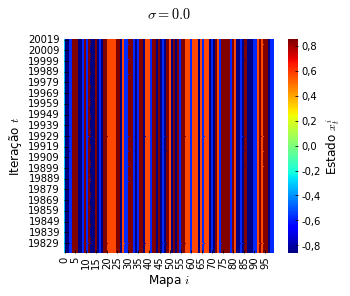

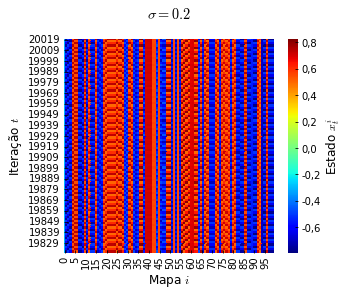

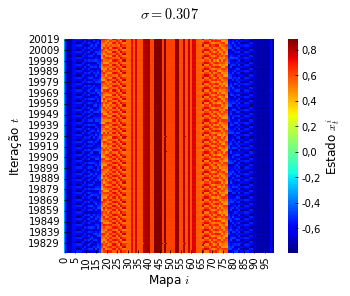

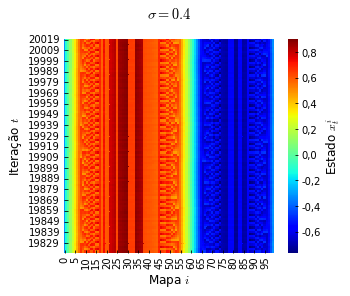

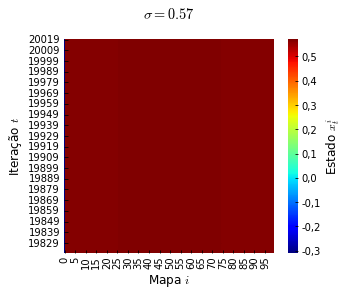

In [26]:
spatial_temporal(nlcoupling_s000_r25, periodo=2);
spatial_temporal(nlcoupling_s020_r25, periodo=2);
spatial_temporal(nlcoupling_s0307_r25, periodo=2);
spatial_temporal(nlcoupling_s040_r25, periodo=2);
spatial_temporal(nlcoupling_s057_r25, periodo=2);

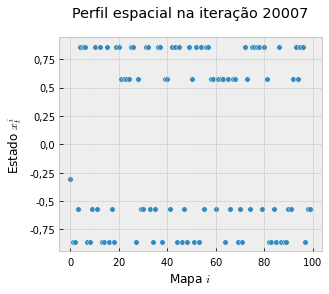

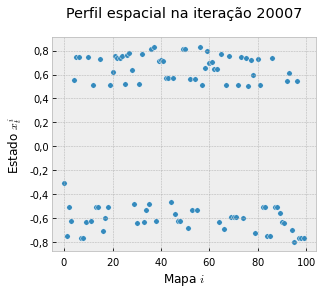

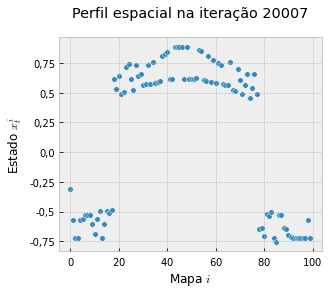

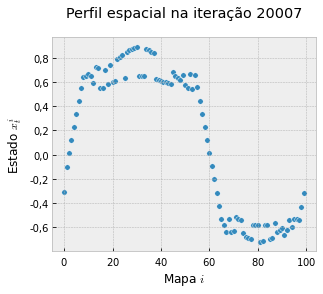

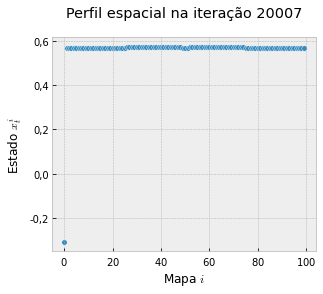

In [27]:
spatial_profile(nlcoupling_s000_r25, 20007);
spatial_profile(nlcoupling_s020_r25, 20007);
spatial_profile(nlcoupling_s0307_r25, 20007);
spatial_profile(nlcoupling_s040_r25, 20007);
spatial_profile(nlcoupling_s057_r25, 20007);

# Analise de quantificação de recorrência espacial


In [28]:
nlcoupling_s000_r25.exec_recurrence_spatial_analysis(ti_map=-2000)
nlcoupling_s020_r25.exec_recurrence_spatial_analysis(ti_map=-2000)
nlcoupling_s0307_r25.exec_recurrence_spatial_analysis(ti_map=-2000)
nlcoupling_s040_r25.exec_recurrence_spatial_analysis(ti_map=-2000)
nlcoupling_s057_r25.exec_recurrence_spatial_analysis(ti_map=-2000)


In [29]:
#rqa_params_005 = nlcoupling_s005_r32.get_params_recurence_analysis_spatial()[['Recurrence_rate', 'Determinism', 'Laminarity']]
#rqa_params_025 = nlcoupling_s025_r32.get_params_recurence_analysis_spatial()[['Recurrence_rate', 'Determinism', 'Laminarity']]
#rqa_params_037 = nlcoupling_s037_r32.get_params_recurence_analysis_spatial()[['Recurrence_rate', 'Determinism', 'Laminarity']]
#rqa_params_075 = nlcoupling_s075_r32.get_params_recurence_analysis_spatial()[['Recurrence_rate', 'Determinism', 'Laminarity']]

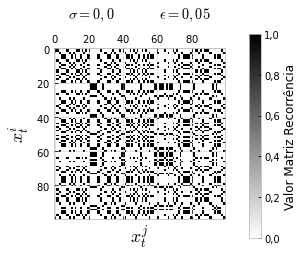

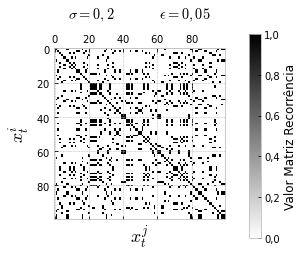

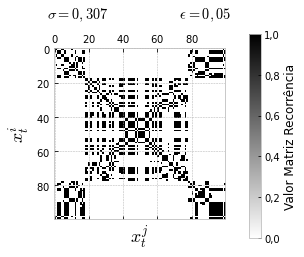

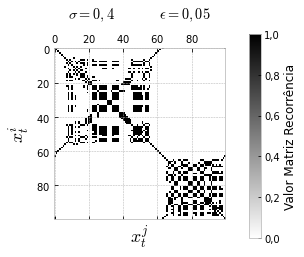

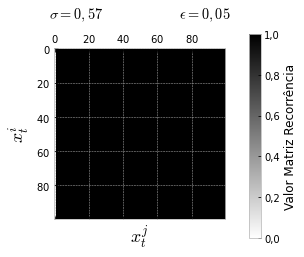

In [30]:
plot_recurrence_matrix(nlcoupling_s000_r25, iteracao=100, figsize=(10,8));
plot_recurrence_matrix(nlcoupling_s020_r25, iteracao=100, figsize=(10,8));
plot_recurrence_matrix(nlcoupling_s0307_r25, iteracao=100, figsize=(10,8));
plot_recurrence_matrix(nlcoupling_s040_r25, iteracao=100, figsize=(10,8));
plot_recurrence_matrix(nlcoupling_s057_r25, iteracao=100, figsize=(10,8));

In [31]:
def plot_REQA_line(rede, periodo,figsize=(12,10), t_i=1600):
    tf = len(rede.get_params_recurence_analysis_spatial())
    iteracoes_selecionadas = np.arange(t_i, tf, periodo)
    rqa_params = rede.get_params_recurence_analysis_spatial()[['Recurrence_rate', 'Determinism', 'Laminarity']].iloc[iteracoes_selecionadas,:]
    fig, ax = plt.subplots(figsize=(figsize[0]*cm, figsize[1]*cm))
    
    sns.lineplot(data=rqa_params['Recurrence_rate'], color='blue', label='$RR$', linewidth=0.9)
    sns.lineplot(data=rqa_params['Determinism'], color='red', label='$DET$', linewidth=0.8)
    sns.lineplot(data=rqa_params['Laminarity'], color='green', label='$LAM$', linewidth=0.9)
    
    ax.set_ylim(0,1.05)
    #ax.set_title(f'${str(rede.get_sigma()).replace(".",",")}$')
    ax.set_ylabel('')
    ax.set_xlabel('iteração t')
    plt.legend(loc='upper right')
    ax.yaxis.set_major_formatter(formatador)
    
    return fig

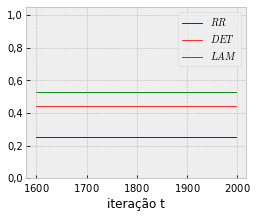

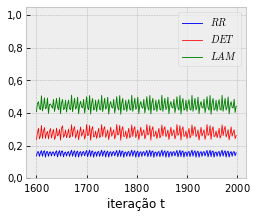

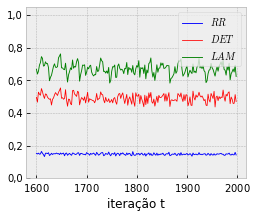

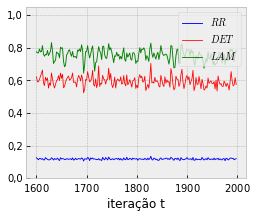

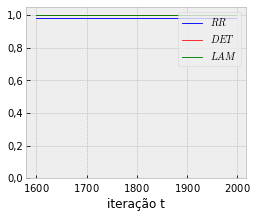

In [32]:
plot_REQA_line(nlcoupling_s000_r25, periodo=2, figsize=(10,8));
plot_REQA_line(nlcoupling_s020_r25, periodo=2, figsize=(10,8));
plot_REQA_line(nlcoupling_s0307_r25, periodo=2, figsize=(10,8));
plot_REQA_line(nlcoupling_s040_r25, periodo=2, figsize=(10,8));
plot_REQA_line(nlcoupling_s057_r25, periodo=2, figsize=(10,8));

> A 𝑣-ésima entrada de 𝑃(𝑣) contém o número de linhas verticais de comprimento 𝑣.

In [33]:
#freq_comprimento_matriz_recorrencia(nlcoupling_s005_r32, 1998, 'Prob_v', n=30, figsize=(20,4));
#freq_comprimento_matriz_recorrencia(nlcoupling_s025_r32, 1998, 'Prob_v', n=30, figsize=(20,4));
#freq_comprimento_matriz_recorrencia(nlcoupling_s037_r32, 1998, 'Prob_v', n=30, figsize=(20,4));

In [34]:
def plot_REQA_hist(rede, periodo, parametros = [], figsize=(12,10), t_i=1000):
    iteracoes_selecionadas = np.arange(t_i, len(rede.get_params_recurence_analysis_spatial()), periodo)
    rqa_params = rede.get_params_recurence_analysis_spatial()[['Recurrence_rate', 'Determinism', 'Laminarity']].iloc[iteracoes_selecionadas,:]
    fig, ax = plt.subplots(figsize=(figsize[0]*cm, figsize[1]*cm))
    sns.histplot(data=rqa_params, x = 'Recurrence_rate',bins=24, binwidth=0.01, ax=ax, color='blue', label='$RR$', stat='count')
    sns.histplot(data=rqa_params, x = 'Determinism',bins=24, binwidth=0.01, ax=ax, color='red', label='$DET$', stat='count')
    sns.histplot(data=rqa_params, x = 'Laminarity',bins=24, binwidth=0.01, ax=ax, color='green', label='$LAM$', stat='count')

    sigma = str(rede.get_sigma()).replace('.',',')

    ax.set_xlim(-0.05,1.05)
    ax.set_title(f'$\sigma = {sigma}$')
    ax.set_ylabel('Contagem')
    ax.set_xlabel('Valor do parâmetro')
    ax.xaxis.set_major_formatter(formatador)
    plt.legend(loc='upper left')
    
    return fig

def plot_REQA_hist_average(rede, periodo, parametros = []):
    iteracoes_selecionadas = np.arange(1000, len(rede.get_params_recurence_analysis_spatial()), periodo)
    rqa_params = rede.get_params_recurence_analysis_spatial()[['Average_diag_length','Average_vert_length']].iloc[iteracoes_selecionadas,:].round(2)
    fig, ax = plt.subplots()
    sns.histplot(data=rqa_params, x = 'Average_diag_length', ax=ax, color='red', label='Avg diag length', stat='count')
    sns.histplot(data=rqa_params, x = 'Average_vert_length', ax=ax, color='green', label='Avg vert length', stat='count')
    #ax.set_xlim(-0.05,1.05)
    ax.set_title(f'${rede.get_sigma():.2f}$')
    ax.set_ylabel('Contagem')
    ax.set_xlabel('Valor do parâmetro')
    ax.xaxis.set_major_formatter(formatador)
    plt.legend()
    
    return fig

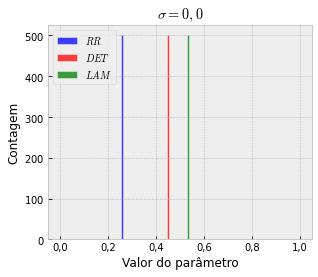

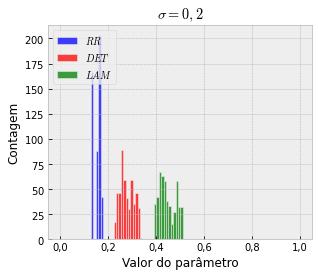

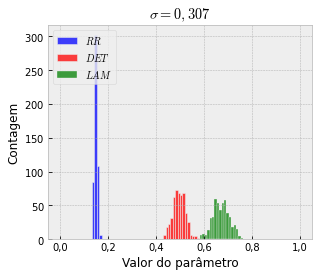

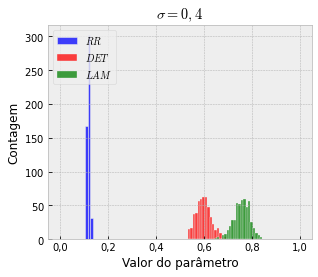

In [35]:
plot_REQA_hist(nlcoupling_s000_r25, periodo=2);
plot_REQA_hist(nlcoupling_s020_r25, periodo=2);
plot_REQA_hist(nlcoupling_s0307_r25, periodo=2);
plot_REQA_hist(nlcoupling_s040_r25, periodo=2);
#plot_REQA_hist(nlcoupling_s057_r25, periodo=2);

# Teste

In [36]:
nlcoupling_s075_r32 = NonlocalCouplingNetwork(condicoes_iniciais_apartir_rede, f, sigma=0.75, raio=0.32, tempo = 20020, FORTRAN=True, EPS=0.05)

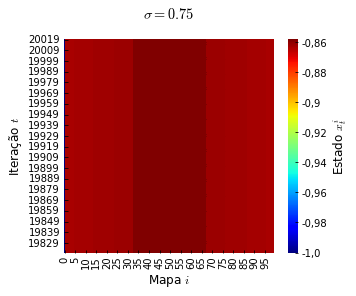

In [37]:
spatial_temporal(nlcoupling_s075_r32, periodo=2);

In [38]:
nlcoupling_s075_r32.exec_recurrence_spatial_analysis(ti_map=-2000)

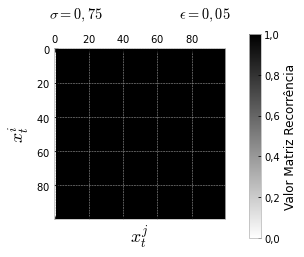

In [39]:
plot_recurrence_matrix(nlcoupling_s075_r32, iteracao=1998, figsize=(10,8));

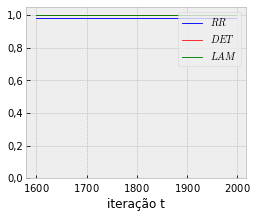

In [40]:
plot_REQA_line(nlcoupling_s075_r32, periodo=2, figsize=(10,8), t_i=1600,);


# espaço de parâmetros

In [41]:
sigmas = np.arange(0.02, 0.52,0.01)
sigmas

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23,
       0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34,
       0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45,
       0.46, 0.47, 0.48, 0.49, 0.5 , 0.51])

In [42]:
raios = np.arange(0.02, 0.52,0.02)
raios

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 ])

In [43]:
print('Quantidade de redes:', len(sigmas) * len(raios))

Quantidade de redes: 1250


In [44]:
taxas_recorrencia = pd.DataFrame({})
determinismos = pd.DataFrame({})
laminaridades = pd.DataFrame({})

taxas_recorrencia_std = pd.DataFrame({})
determinismos_std = pd.DataFrame({})
laminaridades_std = pd.DataFrame({})

In [45]:
%%time

#for sigma in sigmas:
    #for raio in raios:
        #rede = NonlocalCouplingNetwork(condicoes_iniciais_apartir_rede, f, sigma=sigma, raio=raio, tempo = 20020, FORTRAN=True, EPS=0.05)
        #rede.exec_recurrence_spatial_analysis(ti_map=-400)

        #resultado_mean = rede.get_params_recurence_analysis_spatial()[['Recurrence_rate','Determinism','Laminarity']].mean(axis=0)
        #taxas_recorrencia.loc[f'{raio:.2f}', f'{sigma:.2f}'] = resultado_mean.Recurrence_rate
        #determinismos.loc[f'{raio:.2f}', f'{sigma:.2f}'] = resultado_mean.Determinism
        #laminaridades.loc[f'{raio:.2f}', f'{sigma:.2f}'] = resultado_mean.Laminarity

        #resultado_std = rede.get_params_recurence_analysis_spatial()[['Recurrence_rate','Determinism','Laminarity']].std(axis=0)
        #taxas_recorrencia_std.loc[f'{raio:.2f}', f'{sigma:.2f}'] = resultado_std.Recurrence_rate
        #determinismos_std.loc[f'{raio:.2f}', f'{sigma:.2f}'] = resultado_std.Determinism
        #laminaridades_std.loc[f'{raio:.2f}', f'{sigma:.2f}'] = resultado_std.Laminarity


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


## Salvando Objeto

In [46]:
import pickle

# Salvando objeto

## ================== MEDIA =============
#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_taxas_recorrencia.pkl', 'wb') as file:
    #pickle.dump(taxas_recorrencia, file)

#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_determinismos.pkl', 'wb') as file:
    #pickle.dump(determinismos, file)

#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_laminaridades.pkl', 'wb') as file:
    #pickle.dump(laminaridades, file)

## ===================== STD =================
#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_taxas_recorrencia_std.pkl', 'wb') as file:
    #pickle.dump(taxas_recorrencia_std, file)

#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_determinismos_std.pkl', 'wb') as file:
    #pickle.dump(determinismos_std, file)

#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_laminaridades_std.pkl', 'wb') as file:
    #pickle.dump(laminaridades_std, file)



In [47]:
# Abrindo um objeto salvo
arq_taxa_recorrencia = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_taxas_recorrencia.pkl', 'rb')
taxas_recorrencia = pickle.load(arq_taxa_recorrencia)

arq_determinismos = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_determinismos.pkl', 'rb')
determinismos = pickle.load(arq_determinismos)

arq_laminaridades = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_laminaridades.pkl', 'rb')
laminaridades = pickle.load(arq_laminaridades)

arq_taxa_recorrencia_std = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_taxas_recorrencia_std.pkl', 'rb')
taxas_recorrencia_std = pickle.load(arq_taxa_recorrencia_std)

arq_determinismos_std = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_determinismos_std.pkl', 'rb')
determinismos_std = pickle.load(arq_determinismos_std)

arq_laminaridades_std = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/linear_por_partes_laminaridades_std.pkl', 'rb')
laminaridades_std = pickle.load(arq_laminaridades_std)



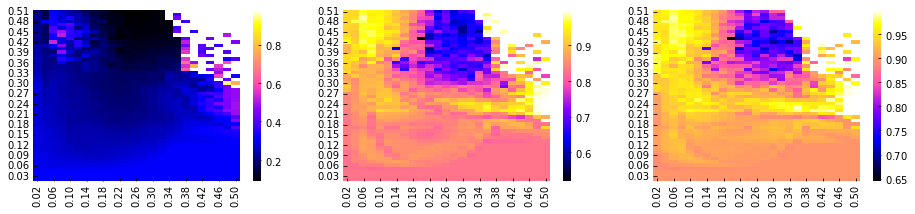

In [48]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(40*cm, 8 * cm))

sns.heatmap(data = taxas_recorrencia.T[::-1], cmap='gnuplot2', ax=ax[0])
sns.heatmap(data = determinismos.T[::-1], cmap='gnuplot2', ax=ax[1])
sns.heatmap(data = laminaridades.T[::-1], cmap='gnuplot2', ax=ax[2])

In [49]:
def plot_espaco_parametros(rr, det, lam, label_cbar):

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(45*cm, 10 * cm))

    rr.columns = [str(x).replace('.', ',') for x in rr.columns]
    rr.index = [str(x).replace('.', ',') for x in rr.index]

    det.columns = [str(x).replace('.', ',') for x in det.columns]
    det.index = [str(x).replace('.', ',') for x in det.index]

    lam.columns = [str(x).replace('.', ',') for x in lam.columns]
    lam.index = [str(x).replace('.', ',') for x in lam.index]


    sns.heatmap(data = rr.T[::-1], cmap='CMRmap', ax=ax[0],
                #vmin=lam.min().min(), vmax=lam.max().max(),
                cbar_kws={"format": formatador, 'label': label_cbar})
    sns.heatmap(data = det.T[::-1], cmap='CMRmap', ax=ax[1],
                #vmin=lam.min().min(), vmax=lam.max().max(),
                cbar_kws={"format": formatador, 'label': label_cbar})
    sns.heatmap(data = lam.T[::-1], cmap='CMRmap', ax=ax[2],
                #vmin=lam.min().min(), vmax=lam.max().max(),
                cbar_kws={"format": formatador, 'label': label_cbar})

    ax[0].set_title('$RR$', fontsize=20,pad=20)
    ax[1].set_title('$DET$', fontsize=20,pad=20)
    ax[2].set_title('$LAM$', fontsize=20,pad=20)

    ax[0].set_ylabel('$\sigma$', fontsize=20,rotation=0, labelpad=20)
    ax[0].set_xlabel('$r$', fontsize=20)
    ax[1].set_xlabel('$r$', fontsize=20)
    ax[2].set_xlabel('$r$', fontsize=20)
    

    return fig

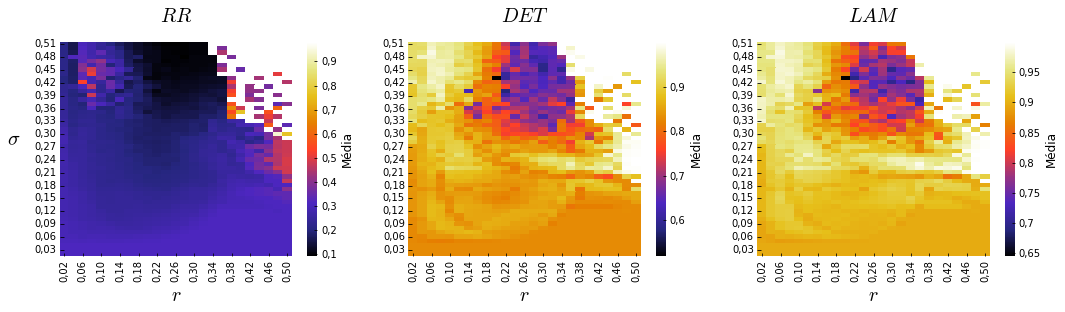

In [50]:
plot_espaco_parametros(
    taxas_recorrencia,
    determinismos,
    laminaridades,
    'Média'
);

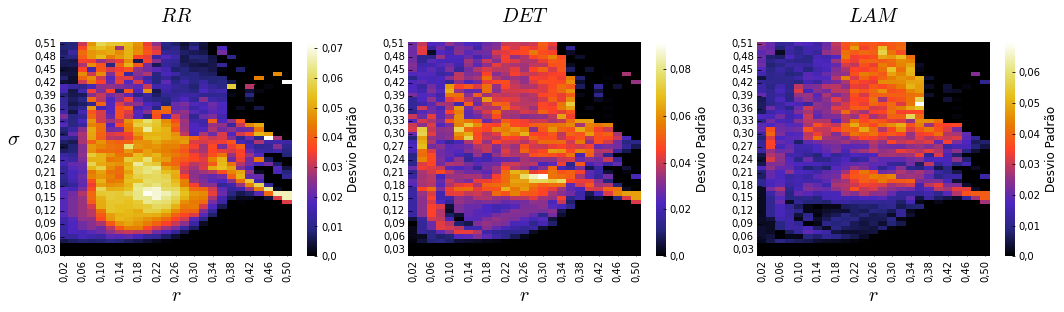

In [51]:
plot_espaco_parametros(
    taxas_recorrencia_std,
    determinismos_std,
    laminaridades_std,
    'Desvio Padrão'
);

# Análise de Autovalores, Autovetores e vetor de sinais

In [52]:
def bivariate_analysis(matriz_recorrencia, k_autovetores = 0, tolerancia = 0.05):
        """
        Calcula os autovalores e autovetores de uma matriz de recorrência espacial

        - Se k_autovetores = 0 realiza a soma de todos os autovetores cujo autovalores
        são maiores que 1.
        - Se k_autovetores = 5, soma os 5 autovetores cujo autovalores
        são maiores que 1.
        """
        autovalores, autovetores = la.eigh(matriz_recorrencia, driver='evd', lower=True)
        #autovalores, autovetores = la.eigh(matriz_recorrencia, driver='evd', lower=False)
        autovalores_sr = pd.Series(autovalores)
        autovetores_df = pd.DataFrame(autovetores)

        if k_autovetores != 0:
            autovalores_selecionados = autovalores_sr[autovalores_sr > 1.].sort_values()
            k_autovalores_selecionados = autovalores_selecionados.iloc[-k_autovetores:]
            indice = k_autovalores_selecionados.index
            autovetores_selecionados = abs(autovetores_df[indice])
            soma_autovetores_selecionados = abs(autovetores_df[indice]).sum(axis=1)
            vetor_sinais = np.array([1 if x > tolerancia else 0 for x in soma_autovetores_selecionados])

            return autovalores_sr, autovetores_selecionados, vetor_sinais
        else:
            autovalores_selecionados = autovalores_sr[autovalores_sr > 1.]
            indice = autovalores_selecionados.index
            autovetores_selecionados = abs(autovetores_df[indice])
            soma_autovetores_selecionados = abs(autovetores_df[indice]).sum(axis=1)
            vetor_sinais = np.array([1 if x > tolerancia else 0 for x in soma_autovetores_selecionados])

            return autovalores_sr, autovetores_selecionados, vetor_sinais

In [53]:
def plot_Bivariate(rede, iteracao, k_autovalores = 1, tolerancia = 0.05):
    sns.set_context('talk')
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25*cm,25*cm))
    fig.tight_layout(pad=2.5)

    matriz_rec = rede.get_matrix_recurrences_spatial()[iteracao]

    img = ax[0][0].matshow(matriz_rec, vmin=0, vmax=1, cmap='binary')
    ax[0][0].tick_params(axis="x", bottom=False, top=True, labelbottom=True, labeltop=False)
    #ax[0][0].set_title('Matriz de Recorrência Espacial', pad=15)
    ax[0][0].set_ylabel('$x^{i}$',rotation=0, fontsize=25, labelpad=20)
    ax[0][0].set_xlabel('$x^{j}$', fontsize=25)
    ax[0][0].grid(False)
    ax[0][0].set_title('(A)', fontsize=20, pad=7)

    e_k, v_k, s =  bivariate_analysis(matriz_rec,k_autovetores = k_autovalores,
                                      tolerancia=tolerancia)

    labels_legends = [r'[$\vec{v}_{'+f'{vetor+1}'+r'}$]' for vetor in range(k_autovalores)]

    sns.scatterplot(data = e_k, color='red', ax=ax[0][1])
    ax[0][1].set_ylabel('$e_k$',fontsize=25, labelpad=15, rotation=0)
    ax[0][1].set_xlabel('$k$', fontsize=20)
    ax[0][1].set_title('(B)', fontsize=20, pad=7)
    
    for coluna in v_k.columns:
        sns.scatterplot(y = v_k[coluna].values, x = v_k.index,  ax=ax[1][0])

    ax[1][0].legend(labels=labels_legends, loc='center right')
    ax[1][0].set_ylabel(r'[$\vec{v_k}$]', rotation=0, labelpad=20)
    ax[1][0].set_xlabel(r'Componente $i$ do autovetor $k$',fontsize=14)
    ax[1][0].set_title('(C)', fontsize=20, pad=7)

    sns.scatterplot(data = s, ax=ax[1][1], color='green', label=r'[$\vec{S}_{i}$]')
    ax[1][1].legend(title = f'$C_{k_autovalores} = {sum(s)}$')
    ax[1][1].set_ylabel(r'[$\vec{S}$]', rotation=0, labelpad=20)
    ax[1][1].set_xlabel(r'Componente $i$ do vetor de sinais $\vec{S}$',fontsize=14)
    ax[1][1].set_title('(D)', fontsize=20, pad=7)

    

    return fig

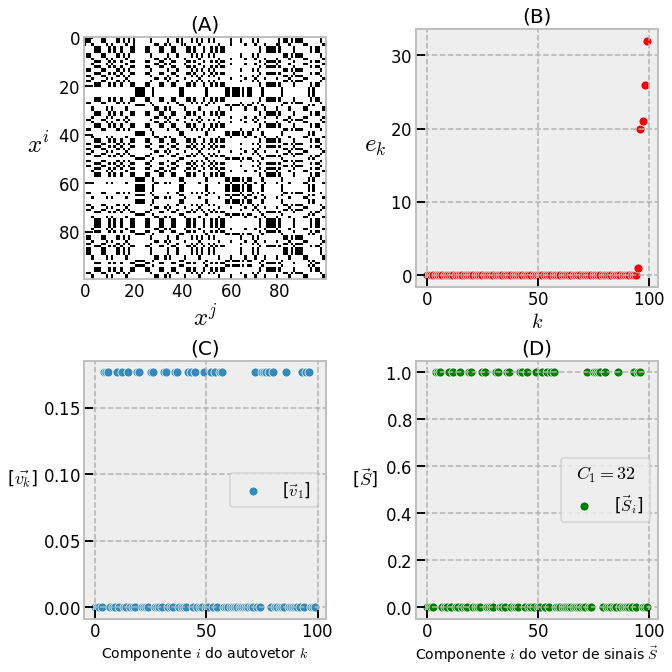

In [54]:
plot_Bivariate(nlcoupling_s000_r25, 1888, k_autovalores=1);

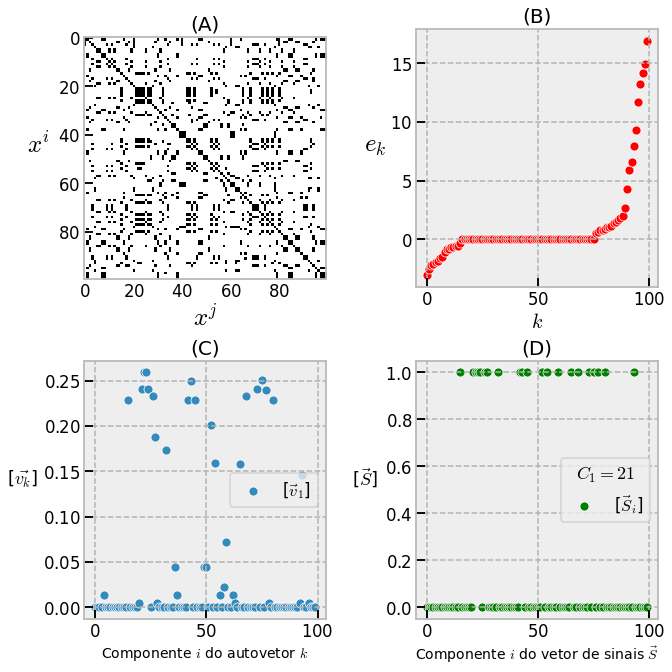

In [55]:
plot_Bivariate(nlcoupling_s020_r25, 1888, k_autovalores=1);

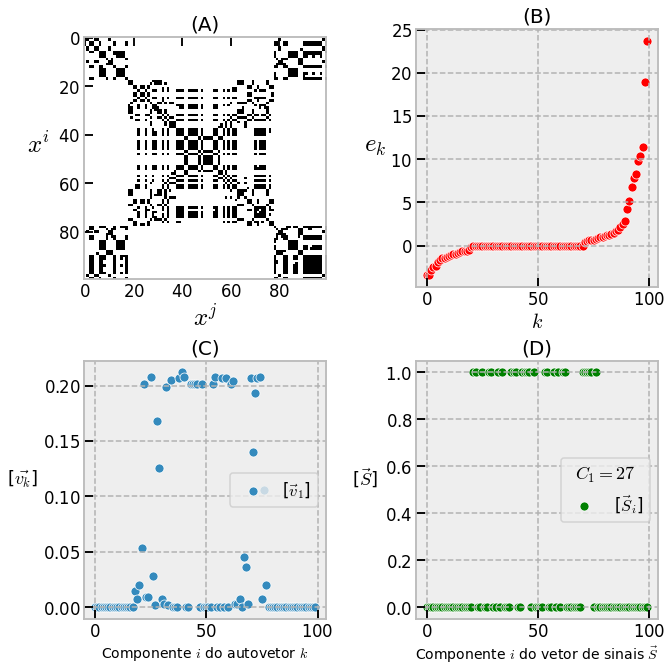

In [56]:
plot_Bivariate(nlcoupling_s0307_r25, 1888, k_autovalores=1);

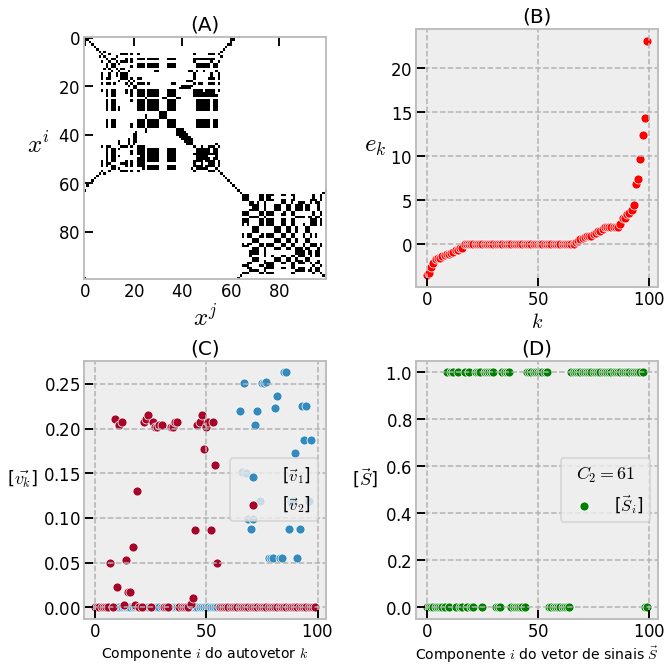

In [57]:
plot_Bivariate(nlcoupling_s040_r25, 1888, k_autovalores=2);

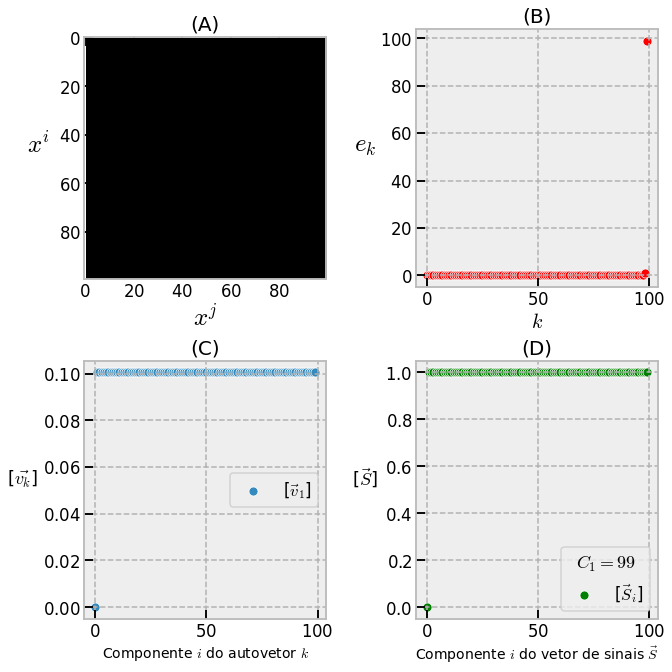

In [58]:
plot_Bivariate(nlcoupling_s057_r25, 1888, k_autovalores=1);

In [59]:
c_k = pd.DataFrame({})

In [60]:
#%%time

#for sigma in sigmas:
    #for raio in raios:
        #rede = NonlocalCouplingNetwork(condicoes_iniciais_apartir_rede, f, sigma=sigma, raio=raio, tempo = 20020, FORTRAN=True, EPS=0.05)
        #rede.exec_recurrence_spatial_analysis(ti_map=-112)

        #_,_, c = bivariate_analysis(rede.get_matrix_recurrences_spatial()[1], k_autovetores = 1, tolerancia = 0.05)
        #c_k.loc[f'{raio:.2f}', f'{sigma:.2f}'] = sum(c)
        
#with open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/espaco_parametros_C_k_linear_por_partes.pkl', 'wb') as file:
    #pickle.dump(c_k, file)

In [61]:
arq_c_k = open('/content/gdrive/MyDrive/Classroom/TCC 2021 Conrado/codigos/espaco_parametros_C_k_linear_por_partes.pkl', 'rb')
c_k = pickle.load(arq_c_k)

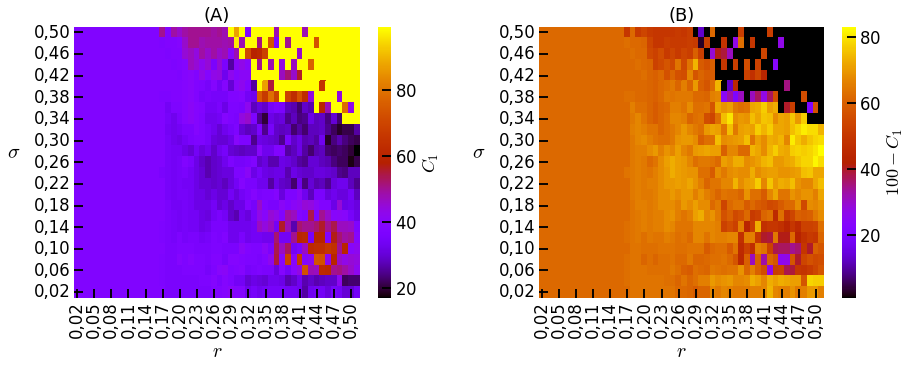

In [62]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(35*cm, 15*cm))
fig.tight_layout(pad=3.5)

c_k.columns = [str(i).replace('.',',') for i in c_k.columns]
c_k.index = [str(i).replace('.',',') for i in c_k.index]

g = sns.heatmap(data = c_k[::-1], cmap='gnuplot',
                cbar_kws={'label': '$C_1$'}, ax=ax[0])

ax[0].set_ylabel('$\sigma$', fontsize=20, labelpad=20, rotation=0)
ax[0].set_xlabel('$r$', fontsize=20)
ax[0].set_title('(A)')


g = sns.heatmap(data = 100-c_k[::-1], cmap='gnuplot',
                cbar_kws={'label': '$100 - C_1$'}, ax=ax[1])

ax[1].set_ylabel('$\sigma$', fontsize=20, labelpad=20, rotation=0)
ax[1].set_xlabel('$r$', fontsize=20)
ax[1].set_title('(B)')

fig;